In [1]:
import sys
import os
import subprocess
import tarfile
import shutil
import math
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
from Bio import motifs
import pickle
from datetime import datetime
from tqdm import tqdm

import boda
from boda.generator.parameters import StraightThroughParameters
from boda.model.mpra_basset import MPRA_Basset
from boda.generator.energy import OverMaxEnergy, StremePenalty
from boda.common import constants, utils

boda_src = os.path.join( os.path.dirname( os.path.dirname( os.getcwd() ) ), 'src' )
sys.path.insert(0, boda_src)

from main import unpack_artifact, model_fn
from pymeme import streme, parse_streme_output

from torch.distributions.categorical import Categorical
from boda.generator.plot_tools import matrix_to_dms, ppm_to_IC, ppm_to_pwm, counts_to_ppm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
class AsiSiRestrictionSite(nn.Module):
    def __init__(self,
                 motif='GCGATCGC',
                 match_threshold=8,
                 **kwrags):
        super().__init__()
        self.motif = motif
        self.match_threshold = match_threshold
        self.get_filters()
        
    def forward(self, x):
        motif_scans = F.conv1d(x, self.filters)
        mask = torch.ge(motif_scans, self.match_threshold)
        out = torch.masked_select(motif_scans, mask)
        return mask, out

    def get_filters(self):
        filters = [utils.dna2tensor(self.motif)]
        filters = torch.stack(filters, dim=0)
        self.register_buffer('filters', filters)    

In [3]:
class IntegratedSampledGradients(nn.Module):
    def __init__(self,
                 target_distributions,
                 predictor,
                 baseline=None,
                 num_samples=1,
                 batch_dim=0,
                 token_dim=-2,
                 cat_dim=-1):
        super().__init__()
        self.predictor = predictor  
        self.baseline = baseline
        self.num_samples = num_samples
        self.batch_dim = batch_dim
        self.token_dim = token_dim
        self.cat_dim = cat_dim
        
        self.register_buffer('target_distributions', target_distributions)
        self.target_distributions.requires_grad_()       
        self.grad = torch.autograd.grad
        
        self.num_classes = self.target_distributions.shape[self.token_dim]
        self.batch_size = self.target_distributions.shape[self.batch_dim]
        self.n_dims = len(self.target_distributions.shape)
        self.repeater = [ 1 for i in range(self.n_dims) ]

        if self.baseline == None:
            base_distribution = 0.25 * torch.ones_like(self.target_distributions)
            self.register_buffer('base_distribution', base_distribution)
        else:
            self.register_buffer('base_distribution', baseline.view(self.target_distributions.shape))
        self.base_distribution.requires_grad_()
        
    def rebatch(self, input):
        return input.unflatten(0, (self.num_samples, self.batch_size)).mean(dim=0)

    def get_samples(self, distribution):
        nucleotide_probs = Categorical(torch.transpose(distribution, self.token_dim, self.cat_dim))
        sampled_idxs = nucleotide_probs.sample((self.num_samples, ))
        sampled_nucleotides_T = F.one_hot(sampled_idxs, num_classes=self.num_classes)        
        sampled_nucleotides = torch.transpose(sampled_nucleotides_T, self.token_dim, self.cat_dim)
        multi_distribution = distribution.repeat(self.num_samples, *self.repeater)
        sampled_nucleotides = sampled_nucleotides - multi_distribution.detach() + multi_distribution 
        return sampled_nucleotides

    def get_gradients(self, distributions):
        samples = self.get_samples(distributions).flatten(0,1)
        predictions = self.rebatch(self.predictor(samples))
        gradients = torch.autograd.grad(predictions.sum(), inputs=distributions, retain_graph=True)[0]
        return gradients

    def get_point_distribution(self, k):
        return self.base_distribution + k * (self.target_distributions - self.base_distribution)

    def integrate_gradients(self, num_steps=10, num_samples=20):
        self.num_samples = num_samples
        line_gradients = []
        for i in tqdm(range(num_steps + 1)):
            slope = i / num_steps
            point_distribution = self.get_point_distribution(slope)
            point_gradients = self.get_gradients(point_distribution)
            line_gradients.append(point_gradients)
        return torch.stack(line_gradients).mean(dim=0)
    
    def get_salient_maps(self, num_steps=10, num_samples=20):
        self.num_samples = num_samples
        gradients = self.integrate_gradients(num_steps).to(self.target_distributions.device)        
        salient_maps =  gradients * self.target_distributions
        return salient_maps.detach()
    

class OverMaxFitness_w_penalty(nn.Module):
    def __init__(self,
                 model,
                 bias_cell=0,
                 ppms=[],
                 score_pct=0,
                 bending_factor=1.0,
                 a_min=-math.inf,
                 a_max=math.inf):
        super().__init__()
        self.model = model
        self.bias_cell = bias_cell
        self.score_pct = score_pct
        self.ppms = ppms
        self.bending_factor = bending_factor
        self.a_min = a_min
        self.a_max = a_max
        
        self.num_ppms = len(self.ppms)      
             
        try: self.model.eval()
        except: pass
        
        if len(self.ppms) == 0:
            self.penalization_flag = False
            self.filters = None
            self.score_thresholds = None
        else:
            self.penalization_flag = True
            self.max_ppm_len = max([ppm.shape[-1] for ppm in self.ppms])
            self.filters_and_thresholds()
    
    def forward(self, x):
        motif_penalty = self.motif_penalty(x)
        preds = self.model(x).clamp(self.a_min, self.a_max)
        fitness = self.over_max_diff(self.bend(preds)) - motif_penalty
        return fitness
    
    def filters_and_thresholds(self):
        penalty_weight = len(self.ppms)
        pwms = []
        score_thresholds = []
        for ppm in self.ppms:
            pwm = ppm_to_pwm(ppm) * np.cbrt(penalty_weight)
            max_score = torch.max(pwm, dim=0)[0].sum()
            pwm_rc = reverse_complement(pwm)
            pwms += [pwm, pwm_rc]
            score_thresholds += 2 * [self.score_pct * max_score]
            penalty_weight -= 1 
        filters = [torch.cat([pwm, pwm.new_zeros(pwm.shape[0], self.max_ppm_len - pwm.shape[-1])], dim=1) for pwm in pwms]
        self.register_buffer('filters', torch.stack(filters, dim=0))
        self.register_buffer('score_thresholds', torch.tensor(score_thresholds))
                   
    def motif_penalty(self, x):
        if self.penalization_flag:
            motif_scores = F.conv1d(x, self.filters)
            score_thresholds = torch.ones_like(motif_scores) * self.score_thresholds[None, :, None]
            mask = torch.ge(motif_scores, score_thresholds) 
            masked_scores = torch.masked_select(motif_scores, mask)
            return masked_scores.sum(dim=-1).mean().div(self.num_ppms * x.shape[0])
        else:
            return 0
    
    def bend(self, x):
        return x - self.bending_factor * (torch.exp(-x) - 1)
    
    def over_max_diff(self, x):
        target = x[...,self.bias_cell]
        non_target_max = x[...,[ i for i in range(x.shape[-1]) if i != self.bias_cell]].max(-1).values
        return target - non_target_max
    

class EntropyFitness(nn.Module):
    def __init__(self, model):
        super().__init__()
        
        self.model = model
        self.model.eval()
        
        self.register_buffer('norm', torch.tensor(3).log())
        self.register_flanks()
    
    def forward(self, x):
        hook = [self.left_flank.repeat(x.shape[0], 1, 1), x, self.right_flank.repeat(x.shape[0], 1, 1)]
        hook = torch.cat(hook, axis=-1)
        hook = self.model(hook)
        hook = boda.graph.utils.shannon_entropy(hook)
        return 1.0 - hook / self.norm
    
    def register_flanks(self):
        left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[-200:]).unsqueeze(0)
        right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:200]).unsqueeze(0)         
        self.register_buffer('left_flank', left_flank)
        self.register_buffer('right_flank', right_flank) 

In [4]:
def contains_restriction(sequence):
    if 'GCGATCGC' in sequence:
        idx = sequence.find('GCGATCGC')
        return idx, True
    elif sequence[:7] == 'CGATCGC':
        idx = -1
        return idx, True
    elif sequence[-7:] == 'GCGATCG':
        idx = 193
        return idx, True
    else:
        return 200, False

In [5]:
if os.path.isdir('./artifacts'):
    shutil.rmtree('./artifacts')
hpo_rec = 'gs://syrgoth/aip_ui_test/model_artifacts__20211113_021200__287348.tar.gz'
unpack_artifact(hpo_rec)

model_dir = './artifacts'
model = model_fn(model_dir)
#model.cuda()
model.eval()
print('')

Loaded model from 20211113_021200 in eval mode



archive unpacked in ./


In [7]:
# #! gsutil cp gs://syrgoth/boda_library_design_202112/BODA_asiSI_sequences.txt ./
# #! gsutil cp gs://syrgoth/boda_library_design_202112/boda_design__round_1__20211214.fa ./
    
# with open('BODA_asiSI_sequences.txt', 'r') as f:
#     lines = f.readlines()
    
# sequence_IDs = []
# for line in lines:
#     sequence_IDs.append(line.split()[1])
# sequence_IDs = [sequence_ID for sequence_ID in sequence_IDs if ('dhs' not in sequence_ID) and ('gw' not in sequence_ID)]
    
# fasta_file_name = 'boda_design__round_1__20211214.fa'
# fasta_dict = {}
# with open(fasta_file_name, 'r') as f:
#     for line in f:
#         line_str = str(line)
#         if line_str[0] == '>':
#             my_id = line_str.lstrip('>').rstrip('\n')
#             fasta_dict[my_id] = ''
#         else:
#             fasta_dict[my_id] += line_str.rstrip('\n')
            
# sequences = []
# for sequence_ID in sequence_IDs:
#     sequences.append(fasta_dict[sequence_ID])


#Sagers
! gsutil cp gs://syrgoth/boda_library_design_202112/asiSI_hits__20211215.fa ./
    
fasta_file_name = 'asiSI_hits__20211215.fa'
fasta_dict = {}
with open(fasta_file_name, 'r') as f:
    for line in f:
        line_str = str(line)
        if line_str[0] == '>':
            my_id = line_str.lstrip('>').rstrip('\n')
            fasta_dict[my_id] = ''
        else:
            fasta_dict[my_id] += line_str.rstrip('\n')
            
sequence_IDs = list(fasta_dict.keys())
sequences = list(fasta_dict.values())

Copying gs://syrgoth/boda_library_design_202112/asiSI_hits__20211215.fa...
/ [1 files][ 90.5 KiB/ 90.5 KiB]                                                
Operation completed over 1 objects/90.5 KiB.                                     


In [9]:
site_idxs = []
for sequence in sequences:
    if 'GCGATCGC' in sequence:
        site_idxs.append(sequence.find('GCGATCGC'))
    elif sequence[:7] == 'CGATCGC':
        site_idxs.append(-1)
    elif sequence[-7:] == 'GCGATCG':
        site_idxs.append(193)
print(len(site_idxs))
original_site_idxs = site_idxs

377


In [11]:
eval_batch_size = 50
fitness_fn = EntropyFitness(model=model)

all_salient_maps = []
for batch_start in range(0, len(sequences), eval_batch_size):
    onehot_sequences = torch.stack([utils.dna2tensor(sequence) for sequence in sequences[batch_start:batch_start+50]])
    attributer = IntegratedSampledGradients(onehot_sequences, fitness_fn, num_samples=20)
    attributer.cuda()
    salient_maps = attributer.get_salient_maps(num_steps=100, num_samples=10).cpu()
    all_salient_maps.append(salient_maps)
all_salient_maps = torch.cat(all_salient_maps)

  0%|          | 0/101 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 101/101 [00:05<00:00, 18.79it/s]


In [12]:
for i in range(all_salient_maps.shape[0]):    
    matrix = all_salient_maps[i,:,:]
    contains = True
    while contains:
        sequence_str = sequences[i]
        site_start = site_idxs[i]
        if site_start == -1:
            site_start = 0
            site_end = site_start + 7
        elif site_start == 193:
            site_end = site_start + 7
        else:
            site_end = site_start + 8
        restriction_matrix = matrix[:,site_start:site_end]
        restriction_sequence = sequence[site_start:site_end]
        min_loc = np.unravel_index(np.argmin(restriction_matrix.numpy()), restriction_matrix.numpy().shape)
        nt_letter = constants.STANDARD_NT[min_loc[0]]
        nt_position = site_start + min_loc[1]
        letter_options = sorted(set(constants.STANDARD_NT) - set(nt_letter))
        new_letter = ''.join(random.choice(letter_options))
        new_sequence_str = sequence_str[:nt_position] + new_letter + sequence_str[nt_position + 1:]
        sequences[i] = new_sequence_str
        site_idxs[i], contains = contains_restriction(sequences[i])

In [13]:
for sequence in sequences:
    idx, contains = contains_restriction(sequence)
    if contains:
        print(idx)
        print(sequence[idx:idx+8])

In [14]:
for idx, sequence in enumerate(sequences):
    if 'GCGATCGC' in sequence:
        idx = sequence.find('GCGATCGC')
        print(sequence[idx:idx+8])
    elif sequence[:7] == 'CGATCGC':
        idx = -1
        print(sequence[idx+1:idx+8])
    elif sequence[-7:] == 'GCGATCG':
        idx = 193
        print(sequence[idx:idx+7])

In [15]:
onehot_sequences = torch.stack([utils.dna2tensor(sequence) for sequence in sequences])

# left_flank = utils.dna2tensor(constants.MPRA_UPSTREAM[-200:]).unsqueeze(0)
# right_flank = utils.dna2tensor(constants.MPRA_DOWNSTREAM[:200]).unsqueeze(0)   

# pieces = [left_flank.repeat(onehot_sequences.shape[0], 1, 1), onehot_sequences, right_flank.repeat(onehot_sequences.shape[0], 1, 1)]
# input_tensor = torch.cat( pieces, axis=-1)

In [16]:
restriction_scan = AsiSiRestrictionSite()
masks, out = restriction_scan(onehot_sequences)
site_idxs = masks.nonzero()[:,2].numpy()

In [17]:
out.sum()/8

tensor(0.)

In [18]:
trues = []
for i in range(masks.shape[0]):
    trues.append(bool(torch.any(masks[i,...])))
for entry in trues:
    if entry:
        print('Hey :(')

In [19]:
masks.nonzero()

tensor([], size=(0, 3), dtype=torch.int64)

In [20]:
#file_name = 'BODA_asiSI_synth_sequences_alt.fa'

#Sagers
file_name = 'asiSI_hits__20211215_alt.fa'

with open(file_name, 'w') as ofile:
    for seq_idx, sequence_str in enumerate(sequences):
        seq_name = sequence_IDs[seq_idx]
        ofile.write(">" + seq_name + "\n" + sequence_str + "\n")

20211210_221910__955552__209::hmc__hepg2__0


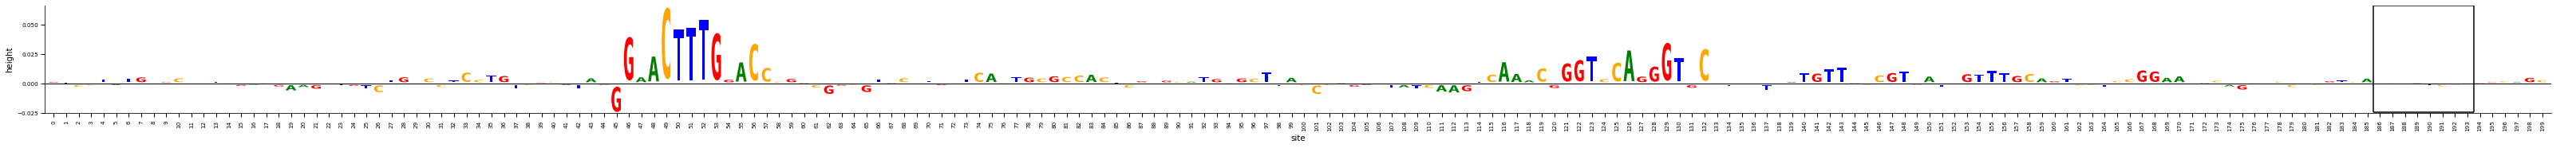

20211210_222248__170431__146::hmc__hepg2__0


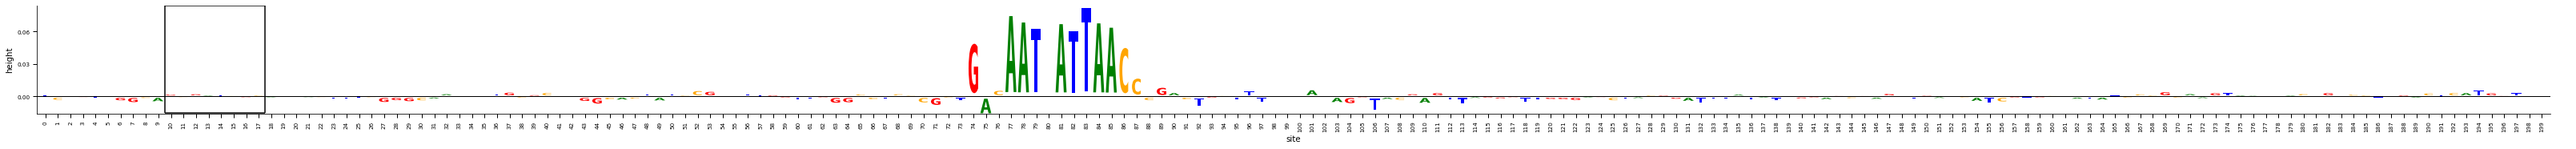

20211210_222248__170431__158::hmc__hepg2__0


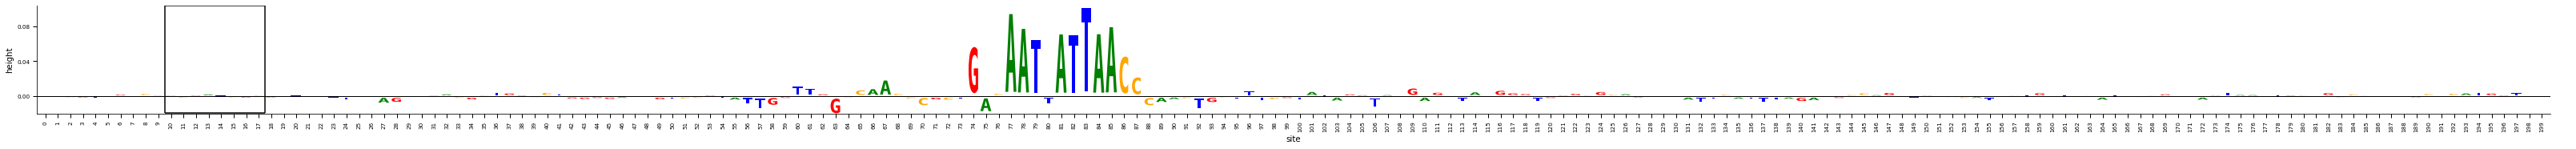

20211210_222400__878831__42::hmc__hepg2__0


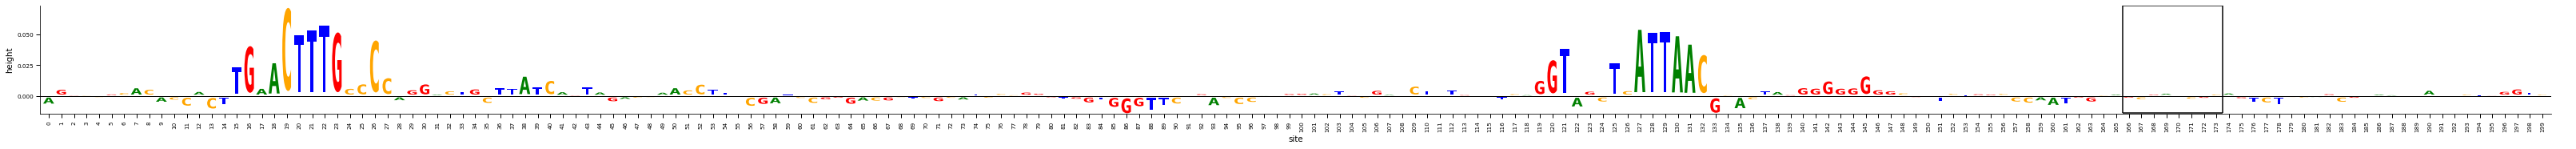

20211210_222400__878831__44::hmc__hepg2__0


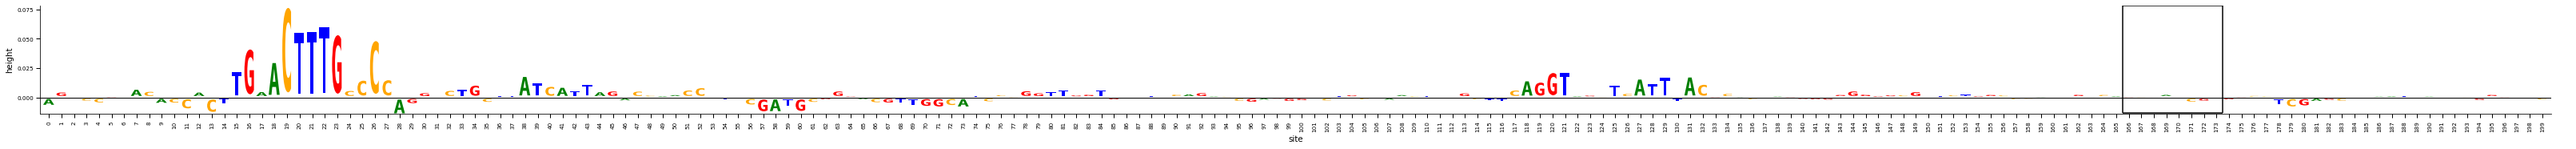

20211210_222625__481558__183::hmc__hepg2__0


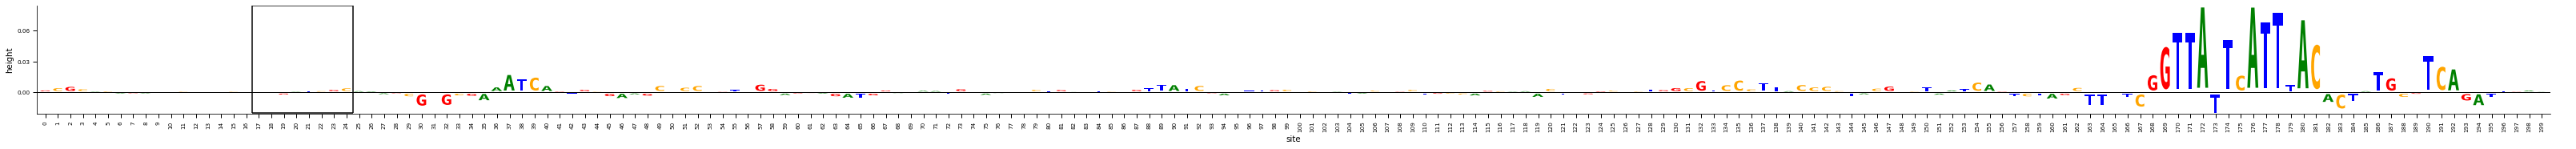

20211210_222736__775920__153::hmc__hepg2__0


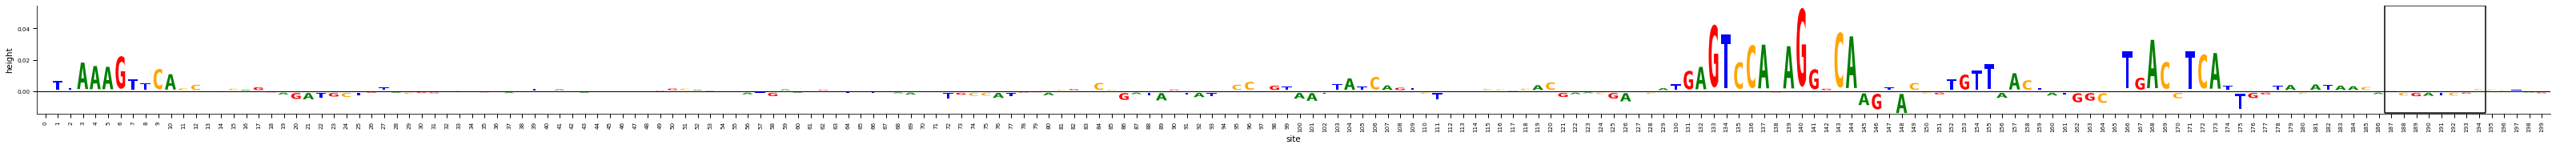

20211210_222736__775920__212::hmc__hepg2__0


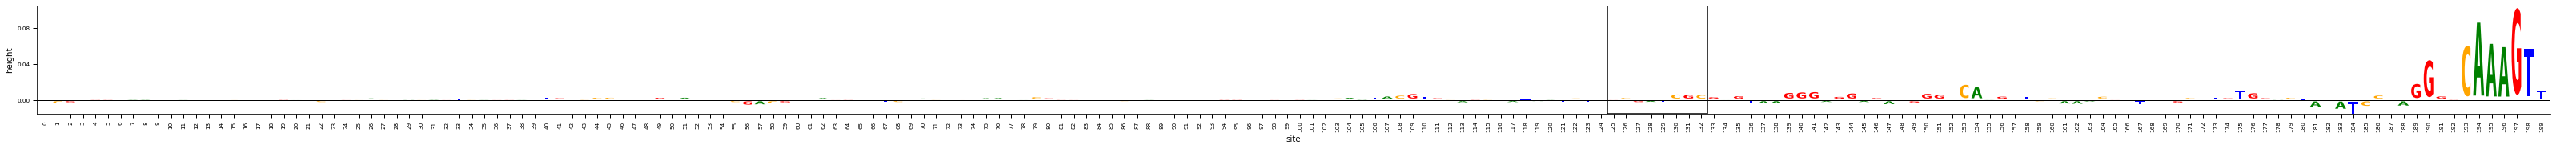

20211207_63610__124703__484::sa__hepg2__0


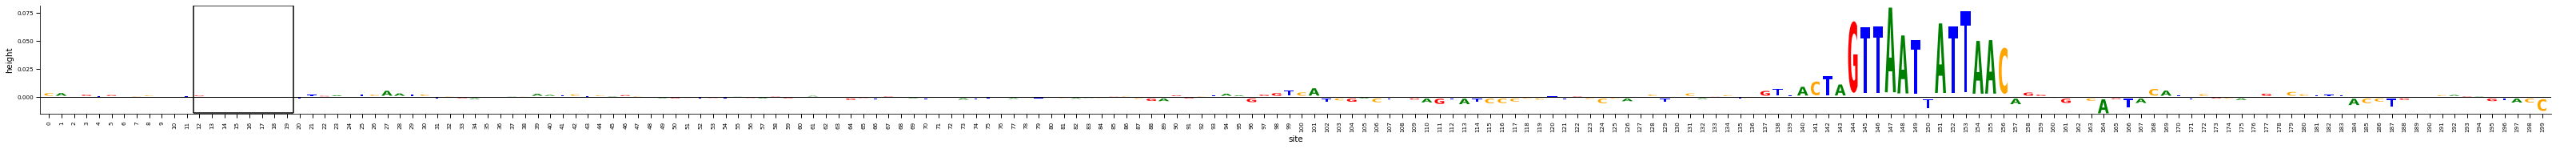

20211207_63610__124703__4246::sa__hepg2__3


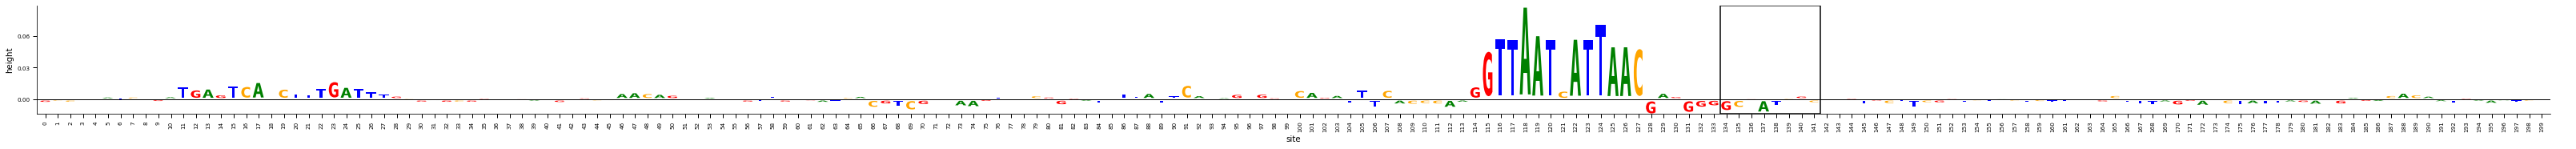

20211207_63610__124703__5093::sa__hepg2__4


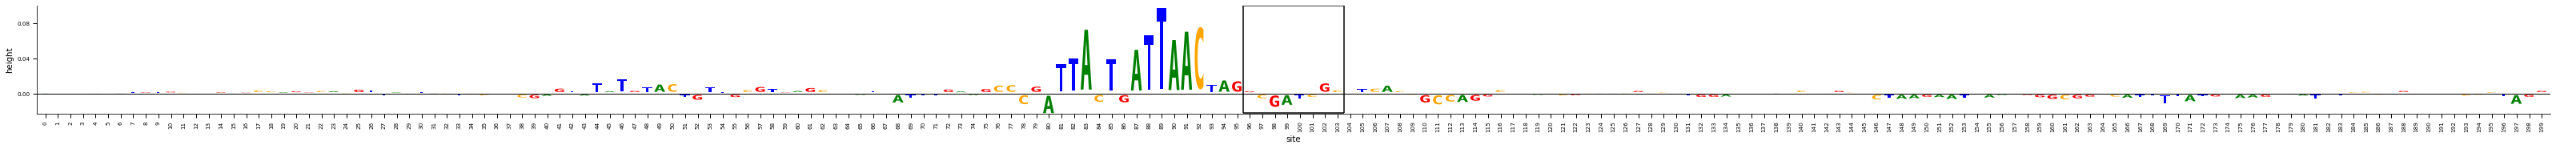

20211207_63610__124703__6183::sa__hepg2__5


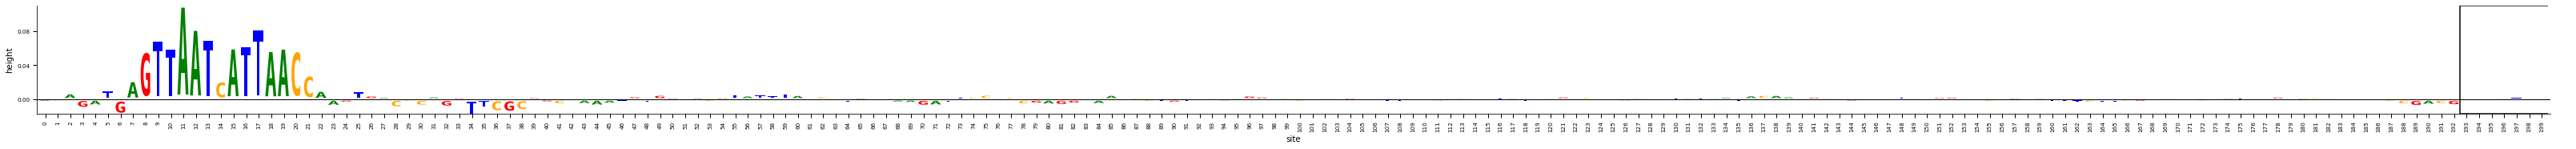

20211207_63610__124703__6221::sa__hepg2__5


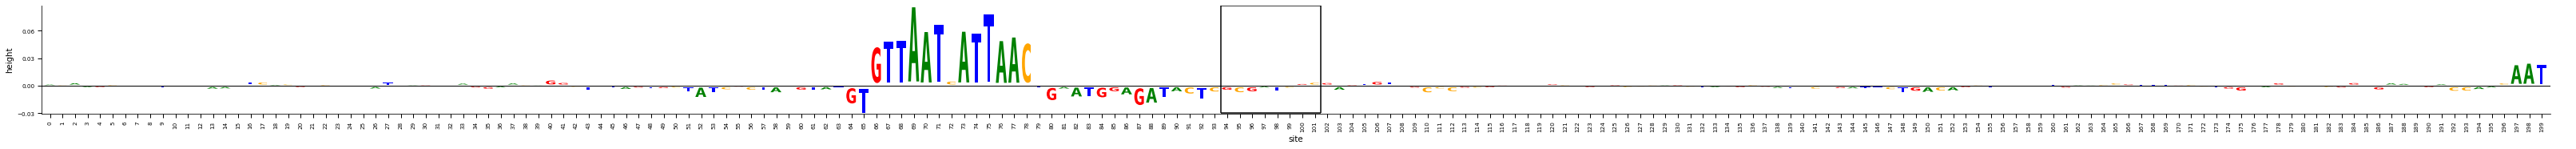

20211207_63610__124703__6387::sa__hepg2__5


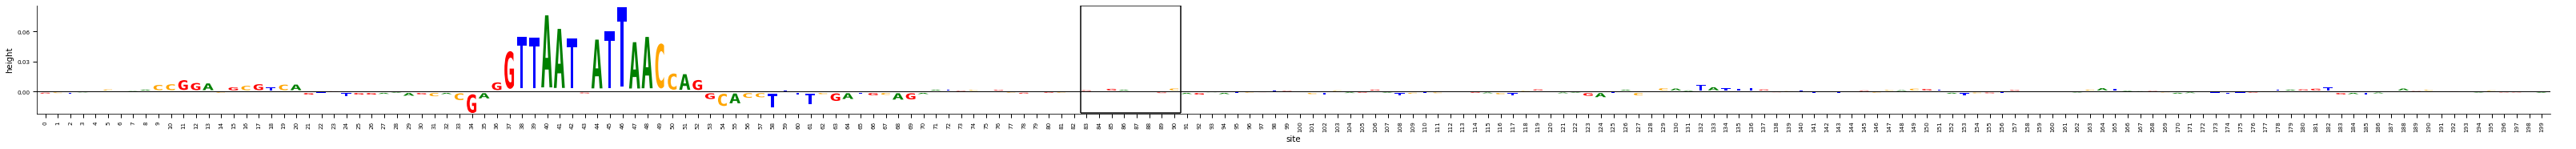

20211207_73549__261982__2229::sa__hepg2__1


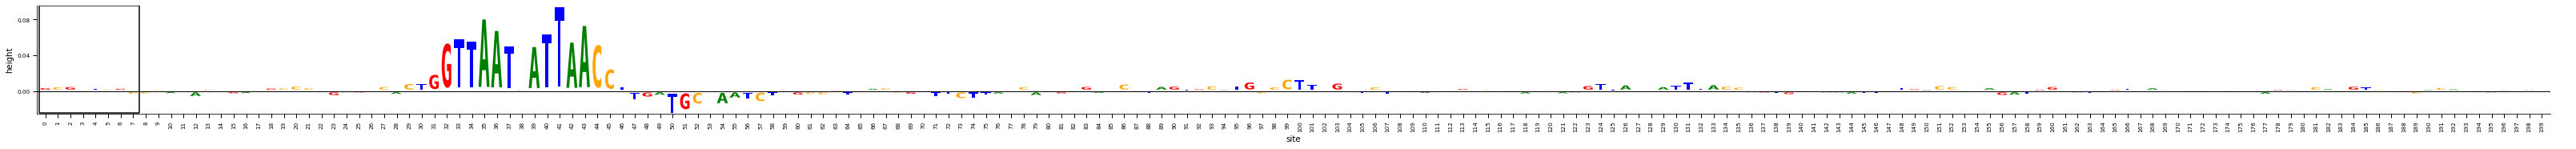

20211207_73549__261982__5391::sa__hepg2__4


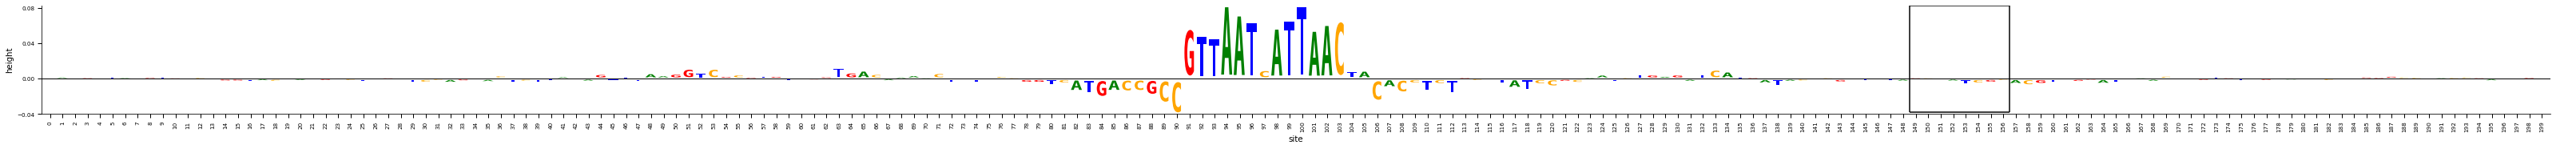

20211207_85512__472183__1836::sa__hepg2__0


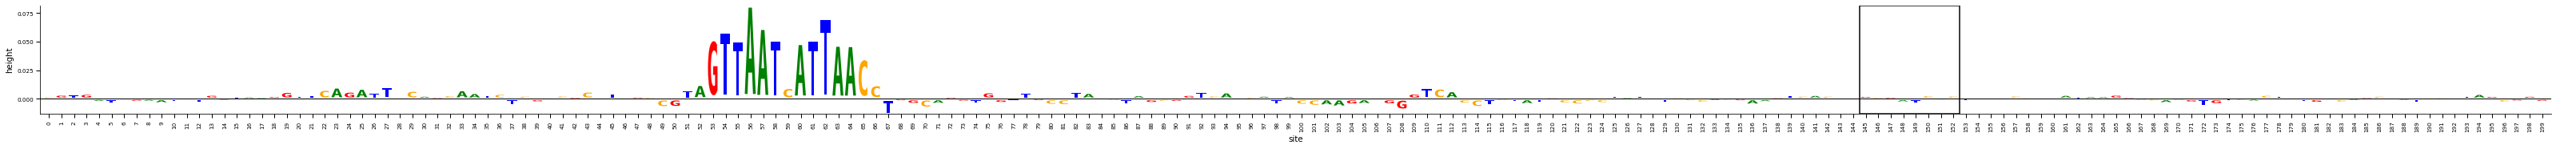

20211207_85512__472183__3165::sa__hepg2__2


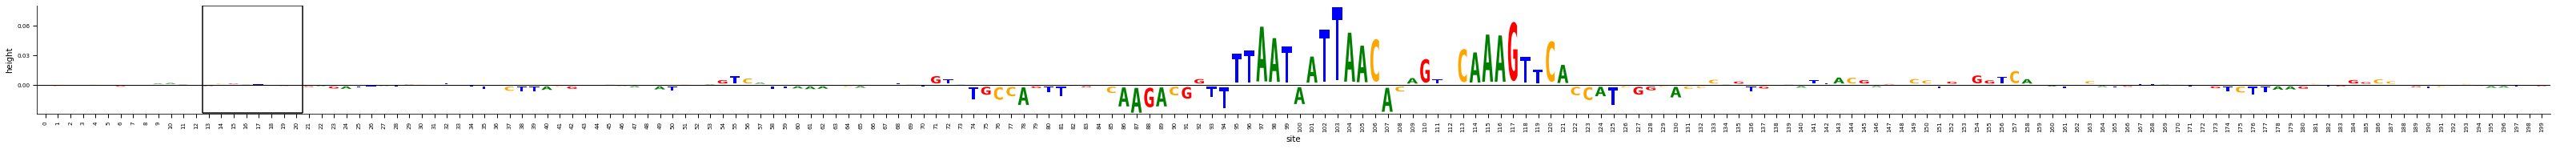

20211207_85512__472183__3232::sa__hepg2__2


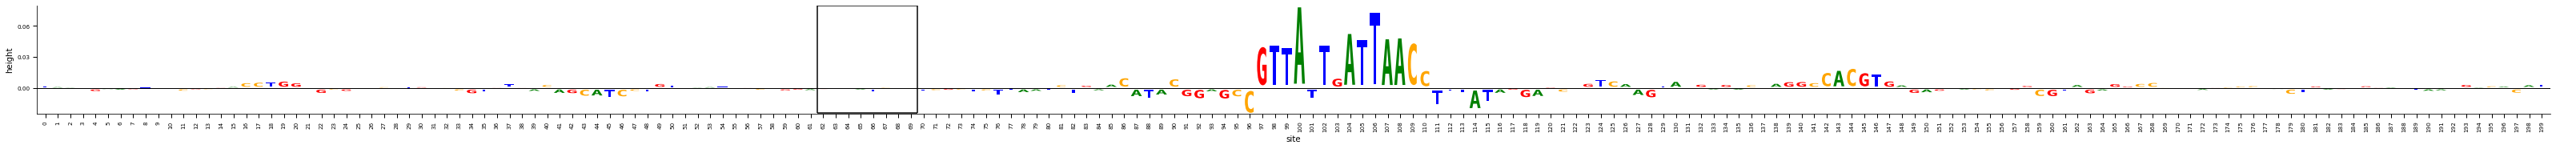

20211207_85512__472183__4938::sa__hepg2__3


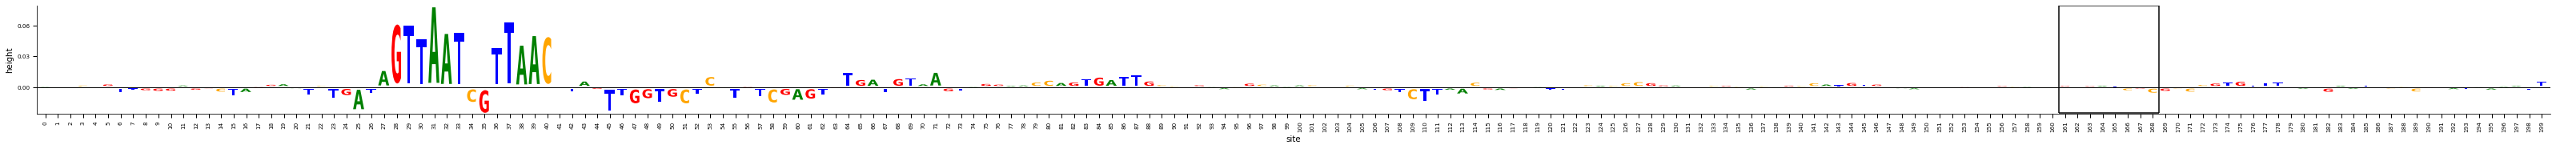

20211207_85512__472183__6549::sa__hepg2__5


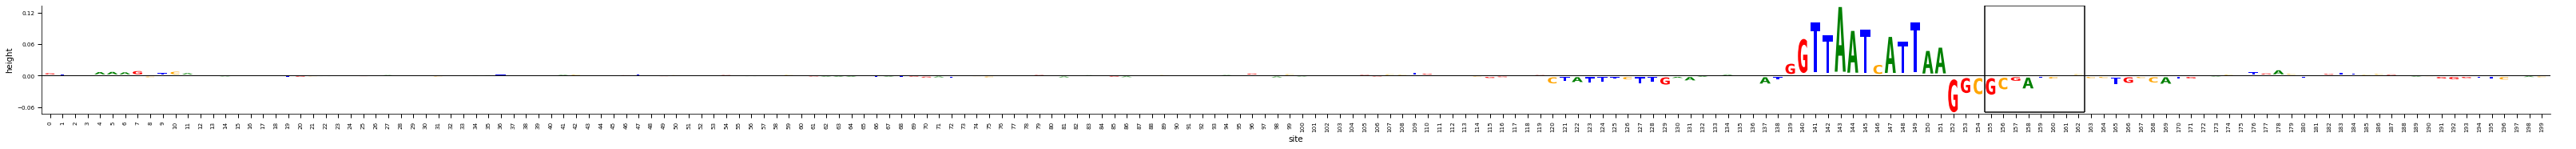

20211207_100944__255626__1331::sa__hepg2__0


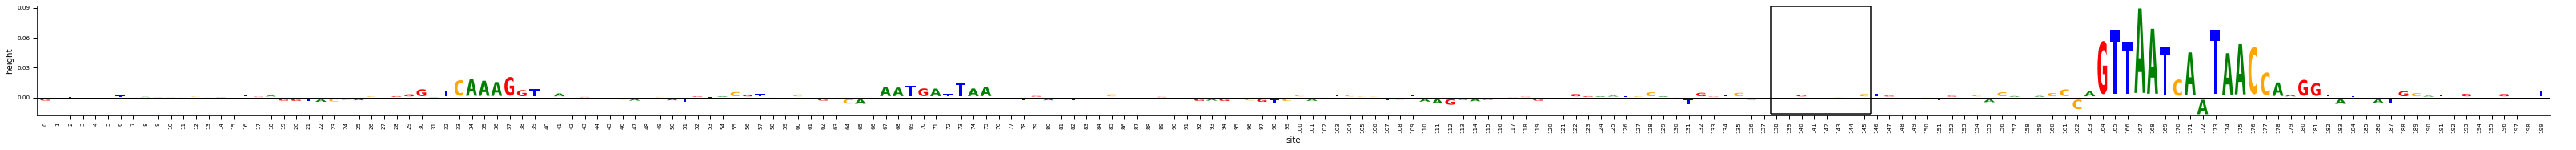

20211207_112927__175796__334::sa__hepg2__0


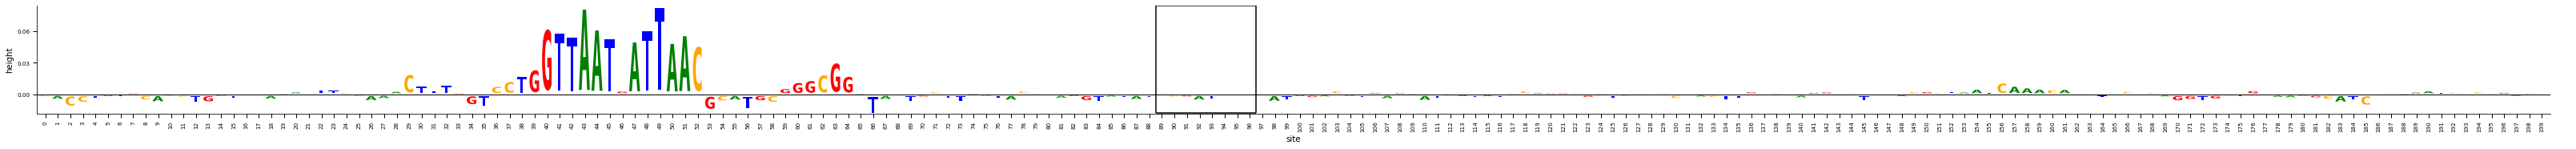

20211207_112927__175796__521::sa__hepg2__0


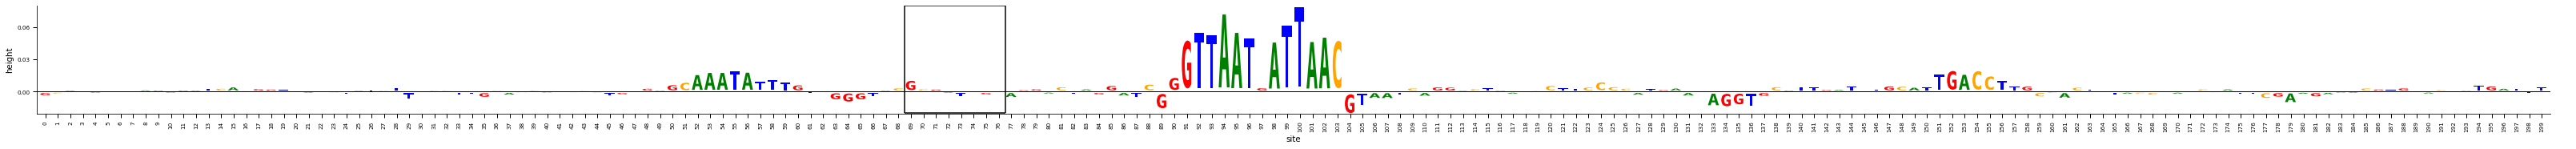

20211207_112927__175796__2084::sa__hepg2__1


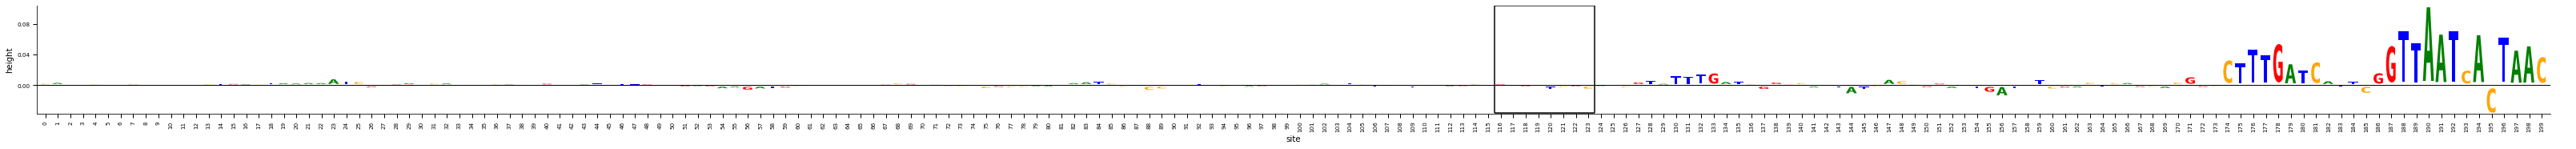

20211207_112927__175796__2816::sa__hepg2__1


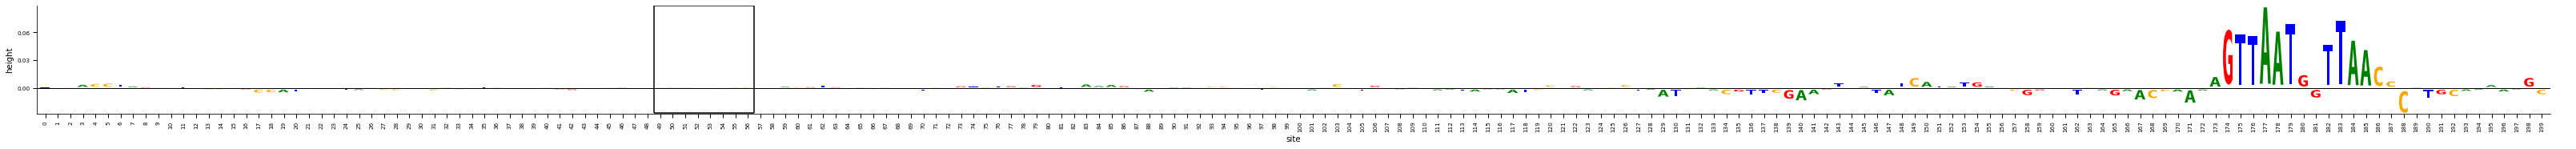

20211207_112927__175796__3356::sa__hepg2__2


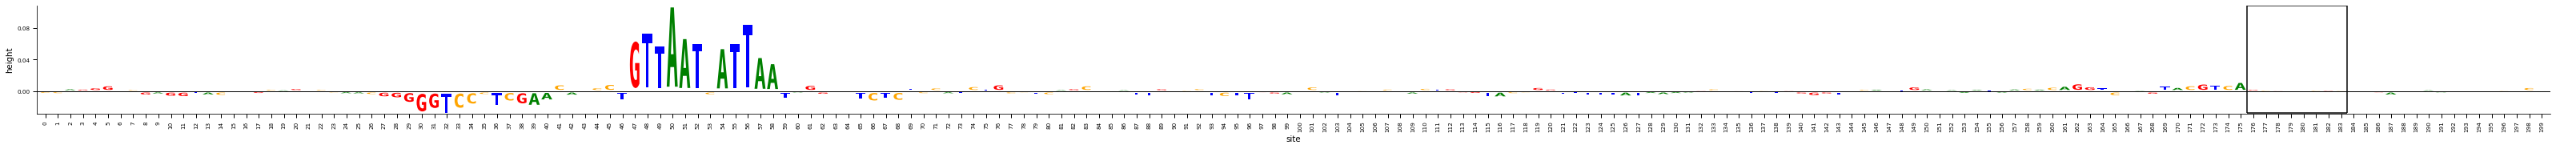

20211210_220819__498877__207::hmc__k562__0


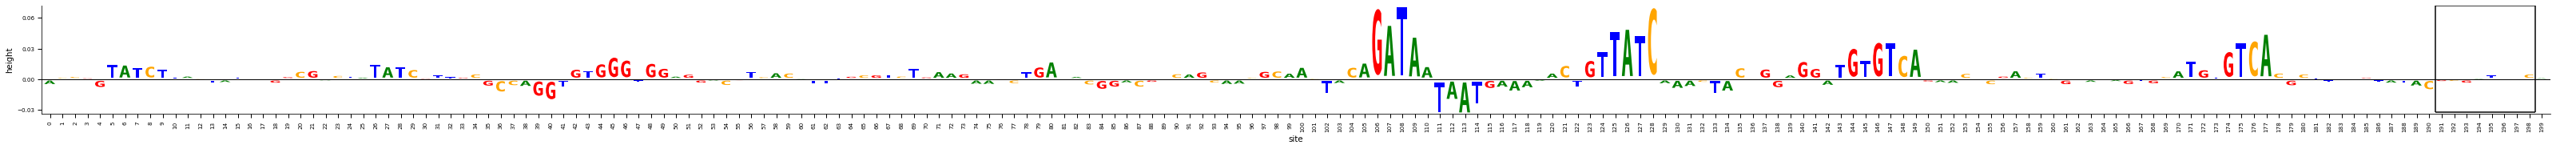

20211210_221309__146215__379::hmc__k562__0


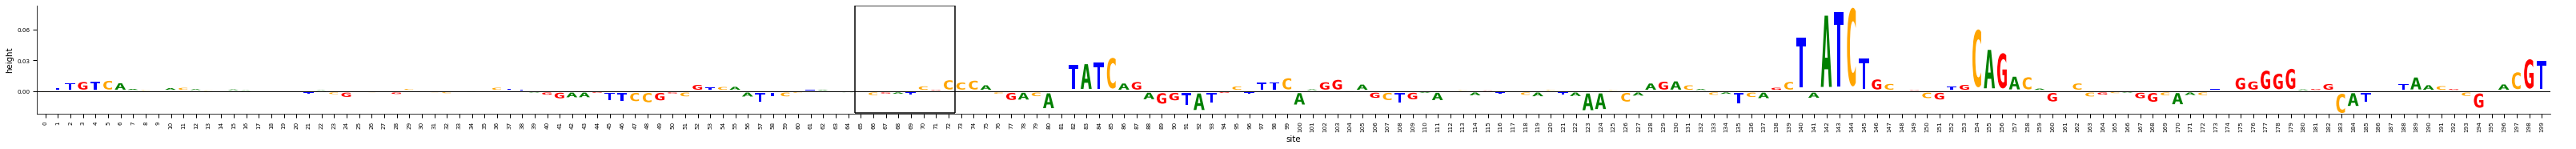

20211210_221309__146215__382::hmc__k562__0


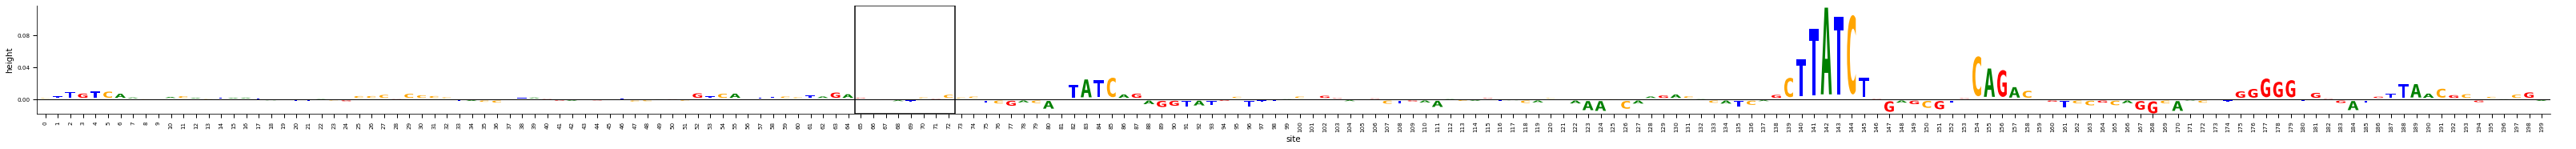

20211210_221421__693103__52::hmc__k562__0


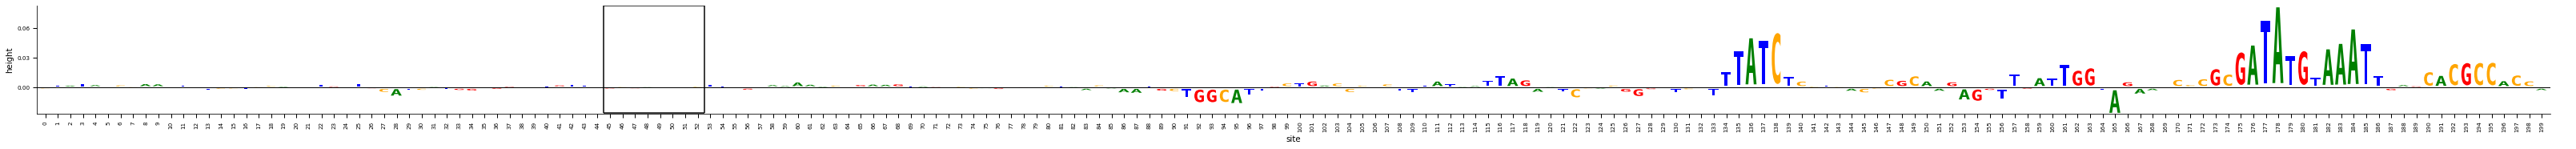

20211210_221421__693103__55::hmc__k562__0


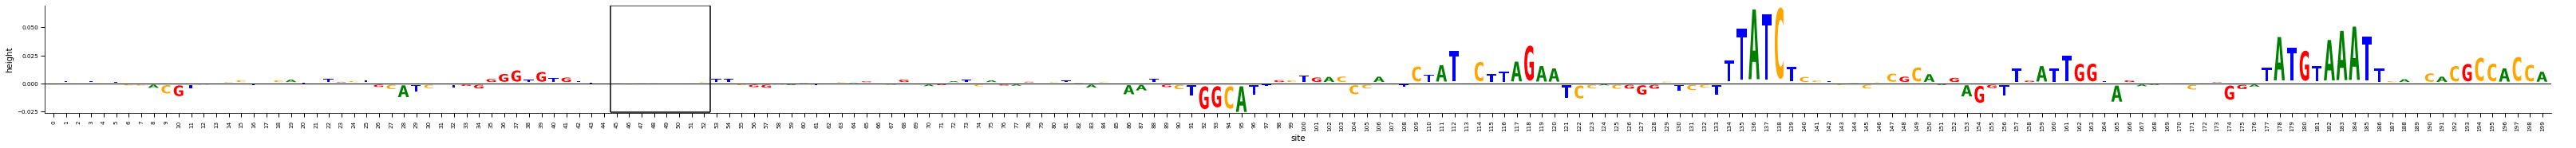

20211210_221421__693103__287::hmc__k562__0


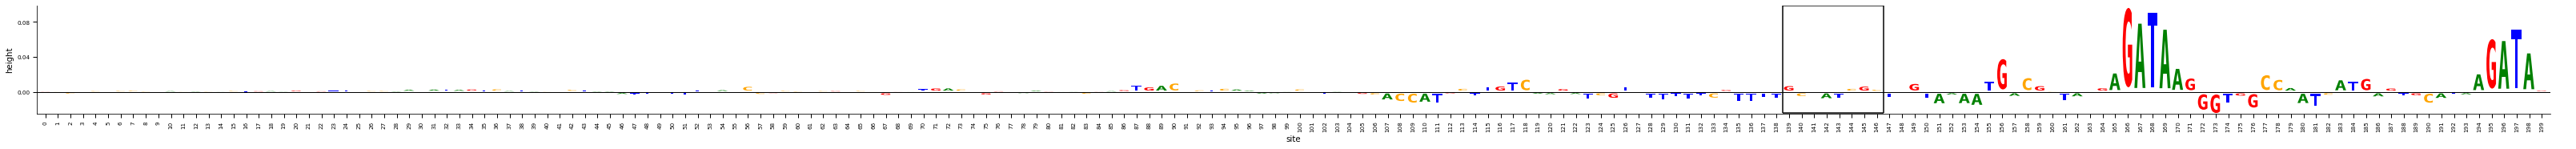

20211207_195336__853804__3568::sa__k562__2


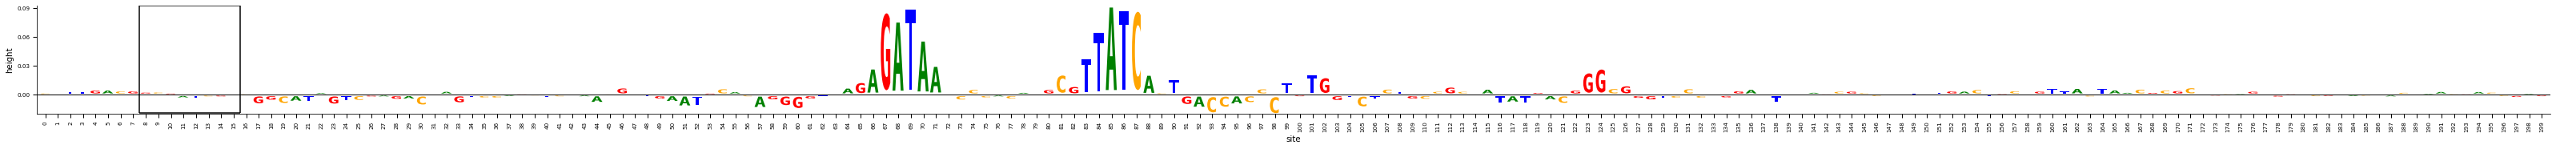

20211207_205407__862697__1268::sa__k562__0


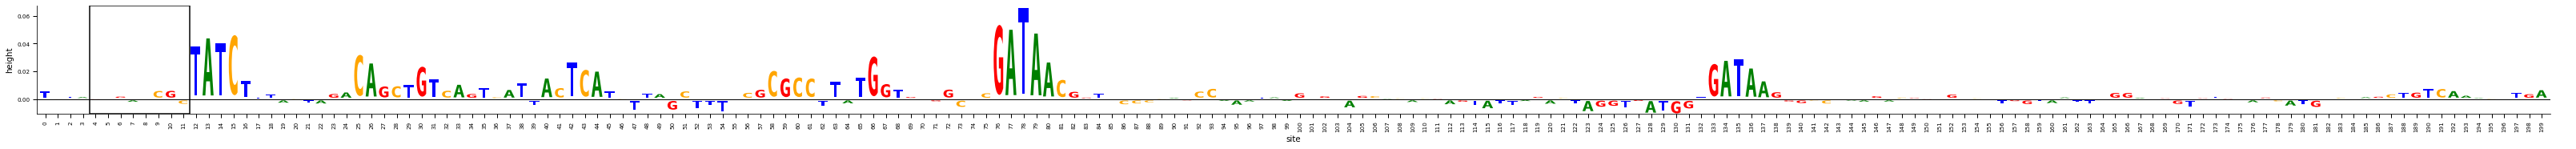

20211207_205407__862697__1559::sa__k562__0


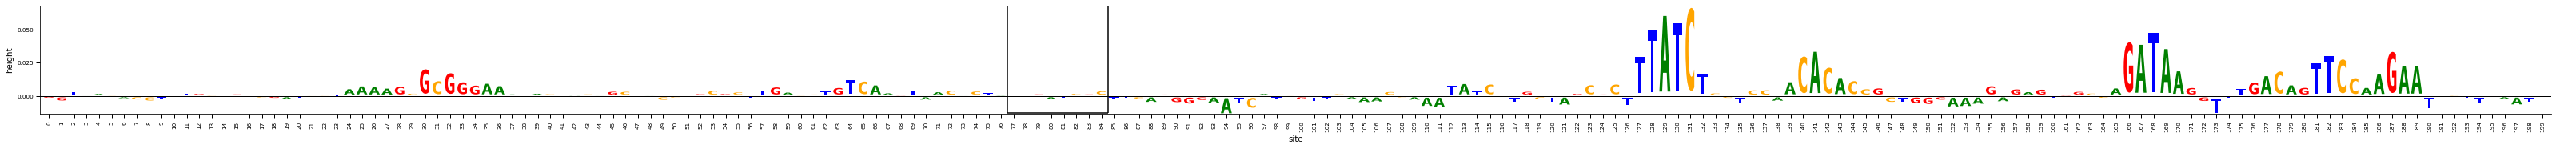

20211207_205407__862697__2219::sa__k562__1


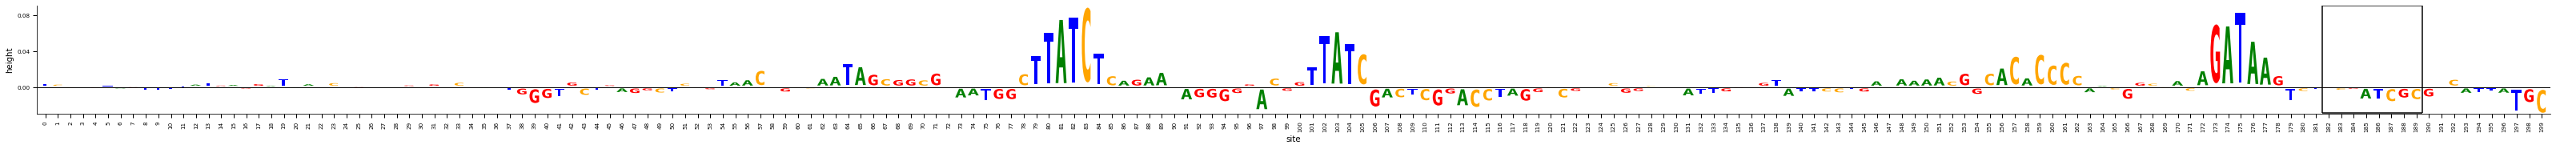

20211207_205407__862697__4854::sa__k562__3


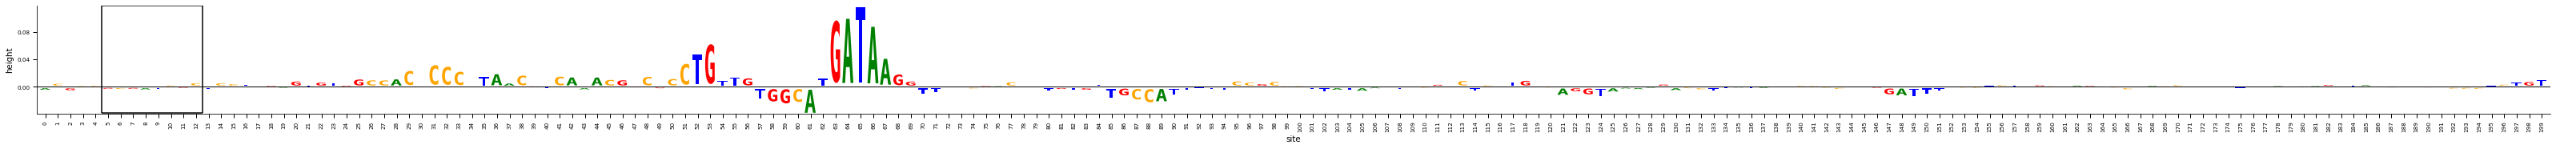

20211207_205407__862697__5569::sa__k562__4


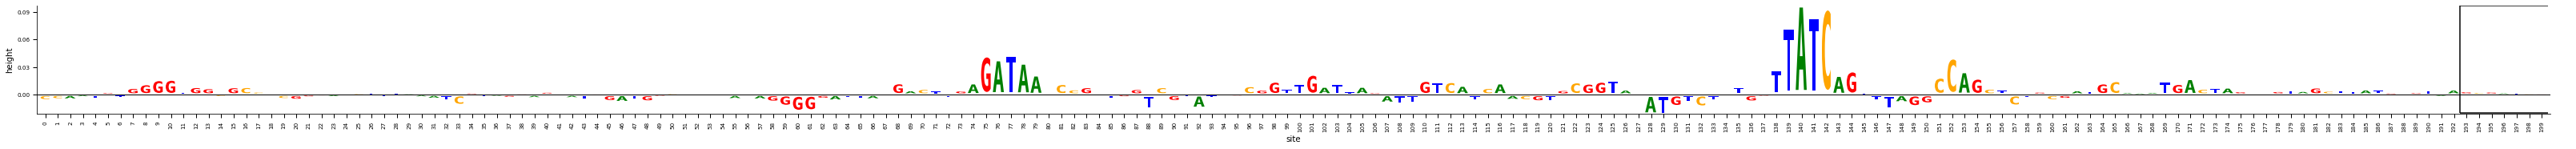

20211207_205407__862697__5914::sa__k562__4


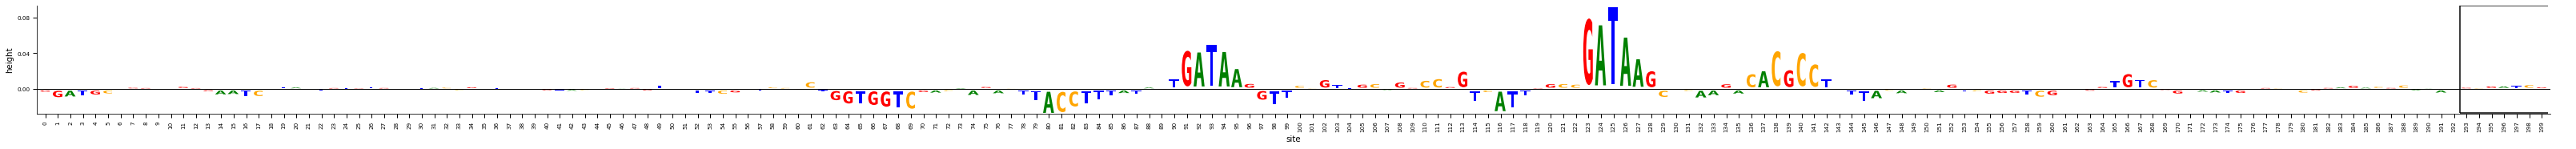

20211207_214935__668330__1048::sa__k562__0


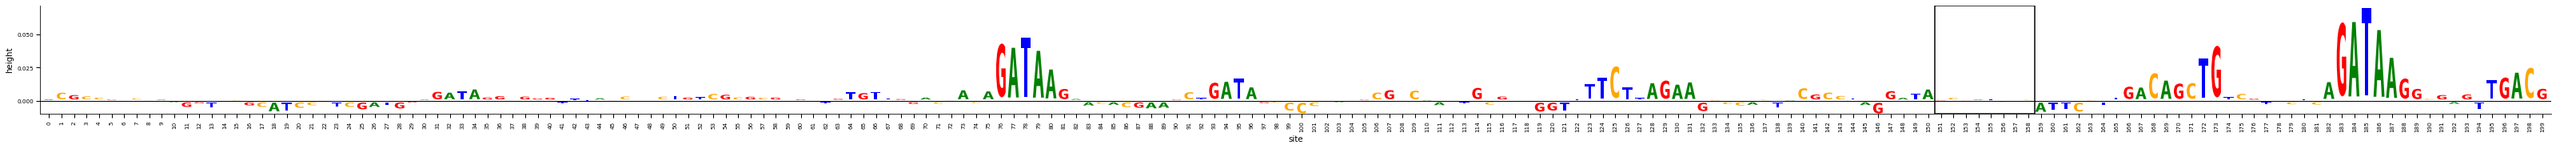

20211207_214935__668330__3680::sa__k562__2


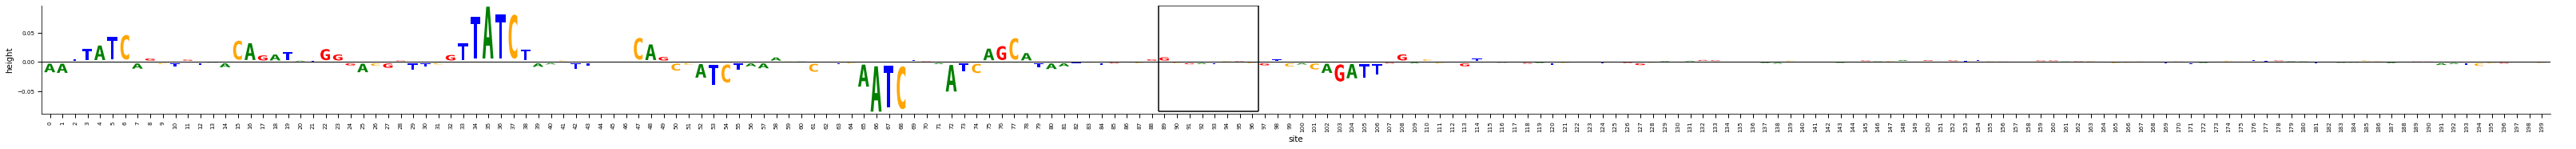

20211207_214935__668330__4645::sa__k562__3


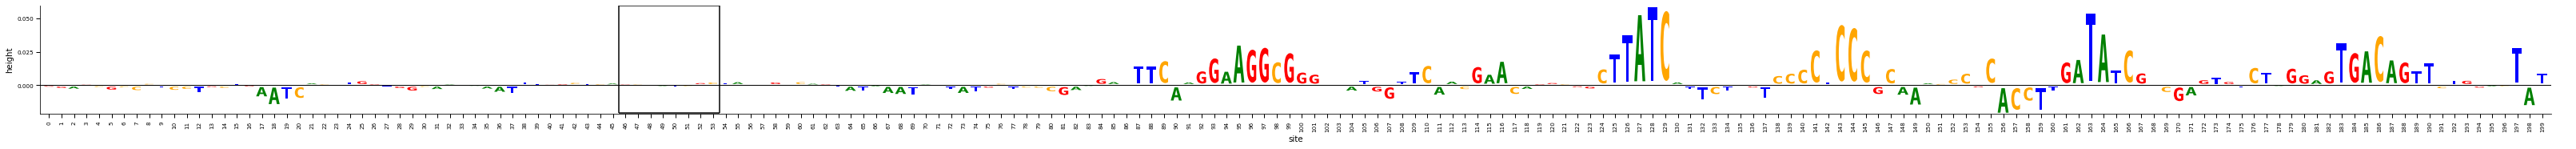

20211207_214935__668330__4773::sa__k562__3


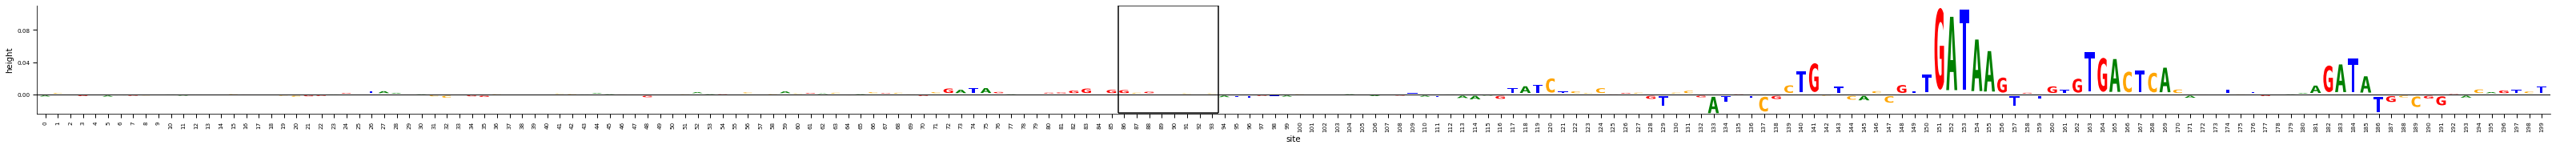

20211207_224529__679056__2203::sa__k562__1


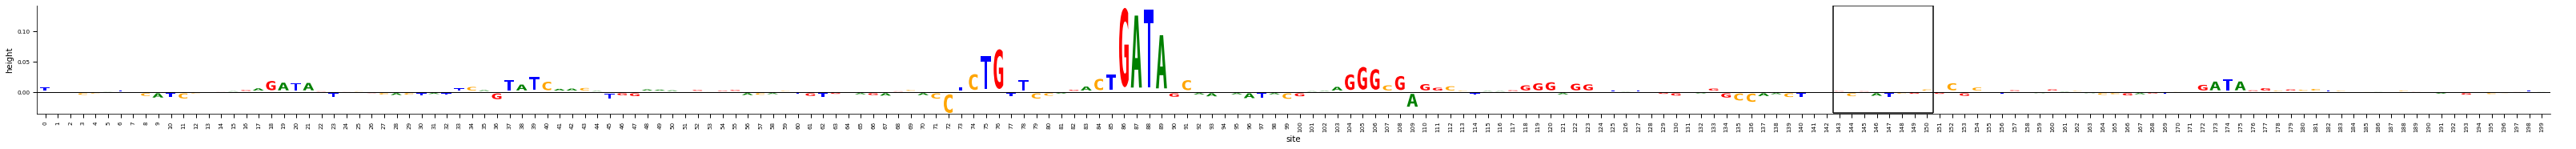

20211207_224529__679056__3685::sa__k562__2


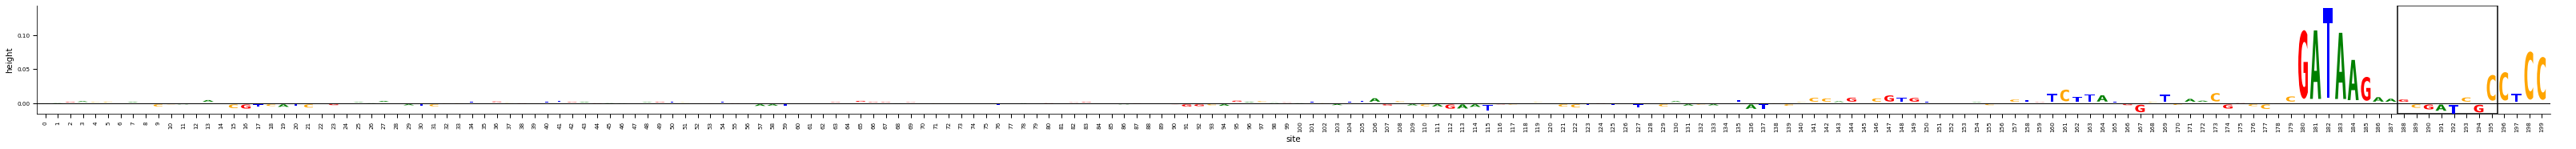

20211207_224529__679056__5265::sa__k562__4


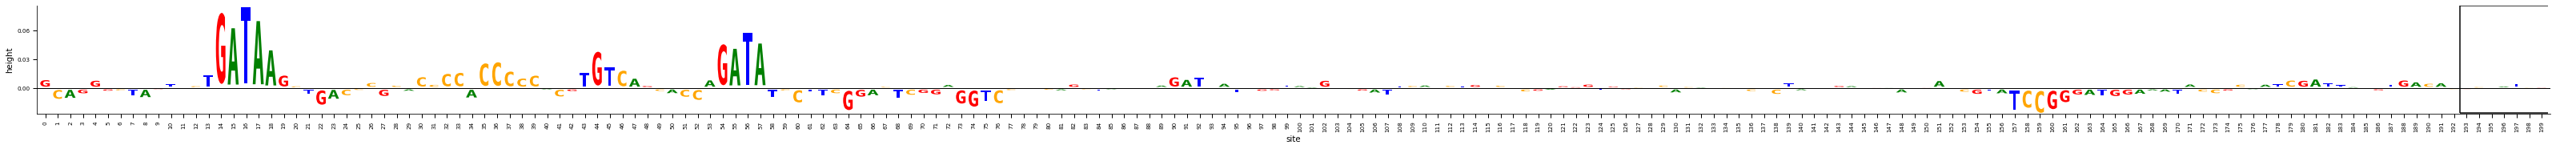

20211207_224529__679056__6539::sa__k562__5


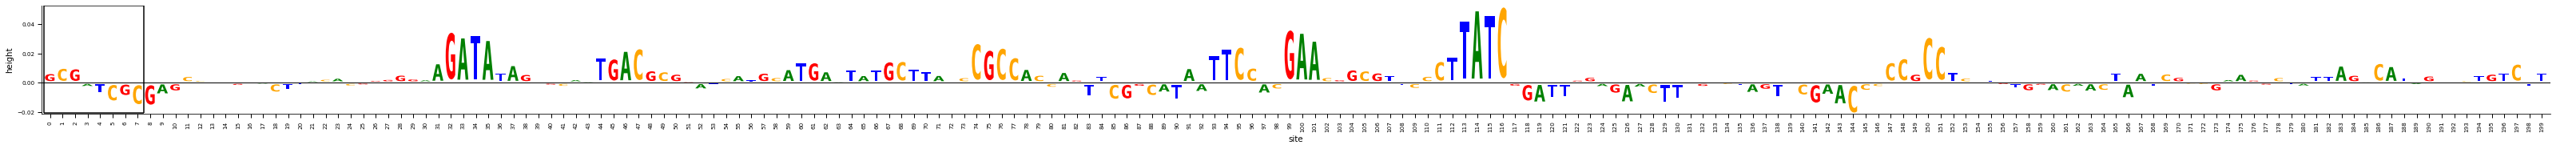

20211207_234119__367484__1031::sa__k562__0


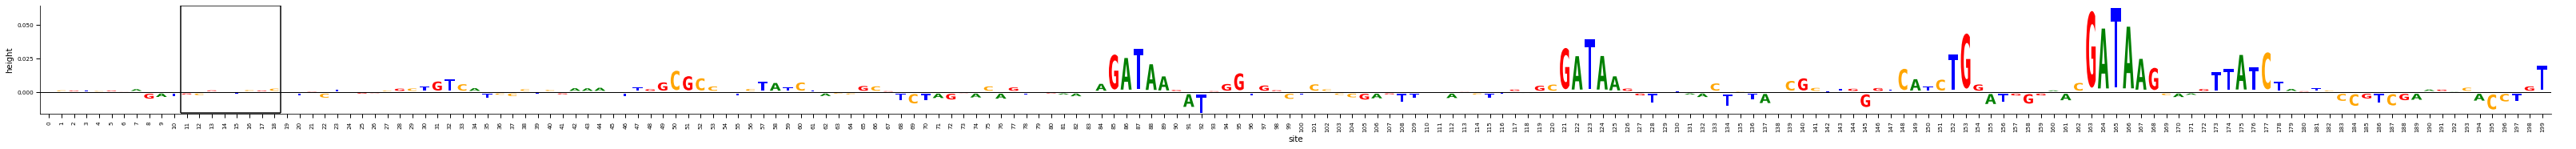

20211207_234119__367484__5067::sa__k562__4


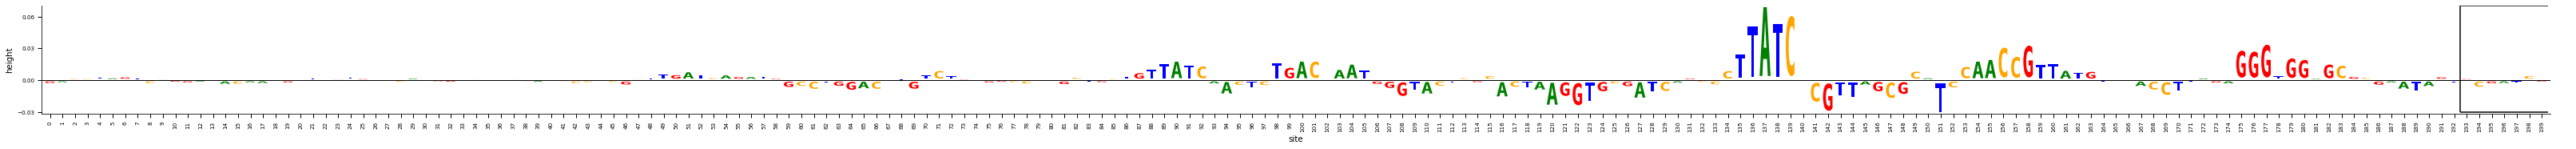

20211207_234119__367484__5976::sa__k562__4


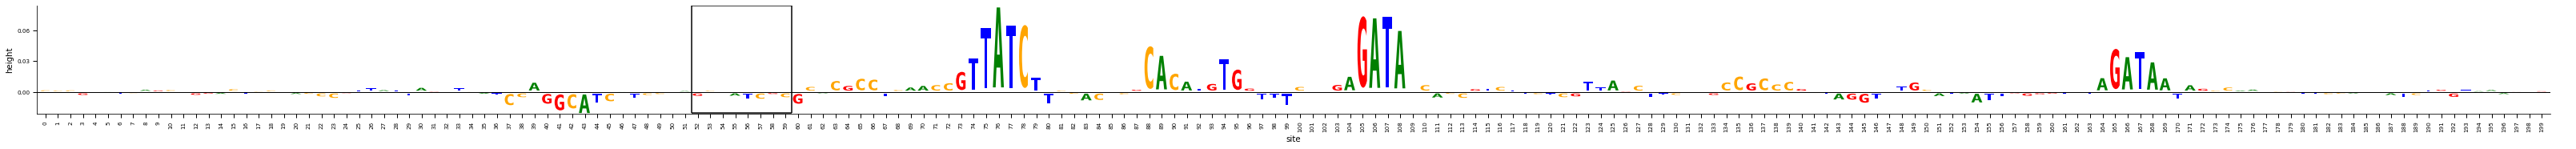

20211210_223336__628085__80::hmc__sknsh__0


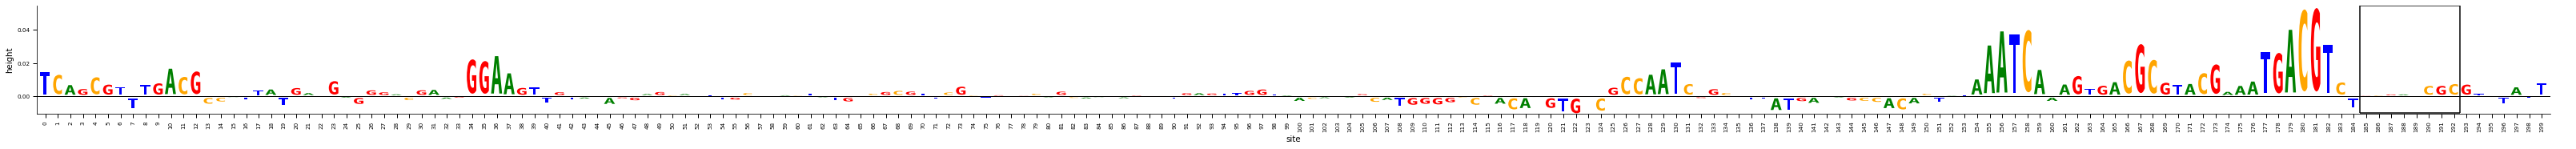

20211210_223336__628085__384::hmc__sknsh__0


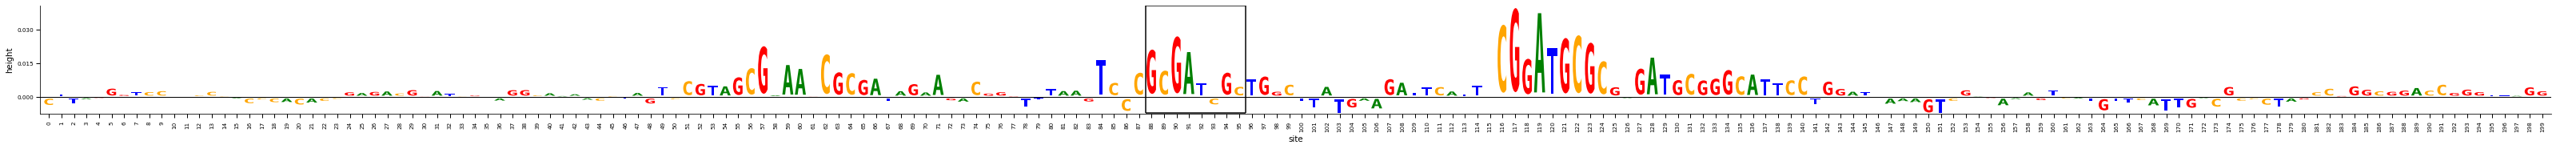

20211210_223449__975596__3::hmc__sknsh__0


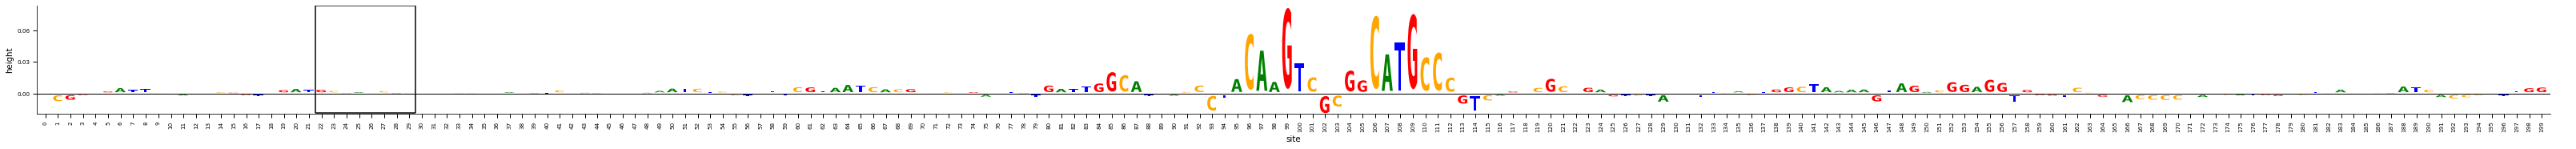

20211210_223601__361569__342::hmc__sknsh__0


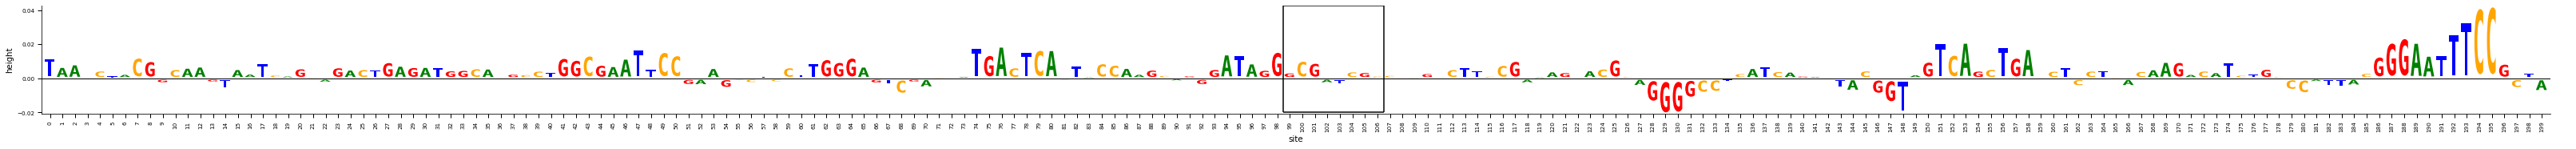

20211210_223713__377193__302::hmc__sknsh__0


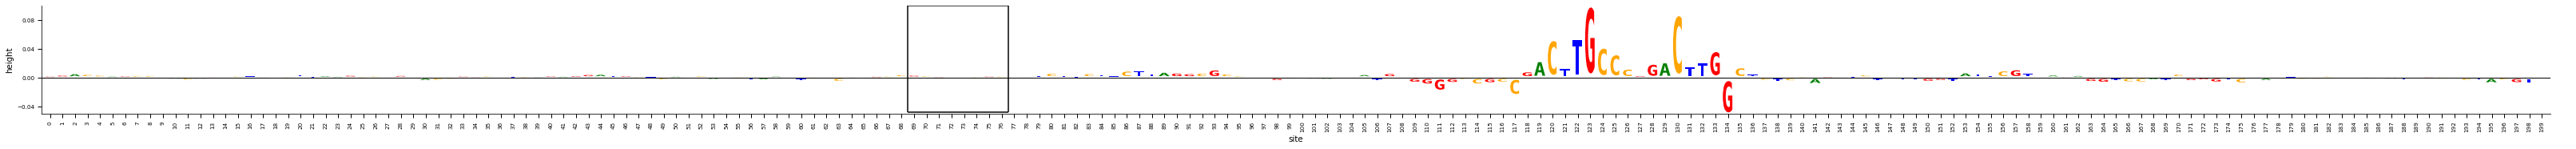

20211210_223825__729421__132::hmc__sknsh__0


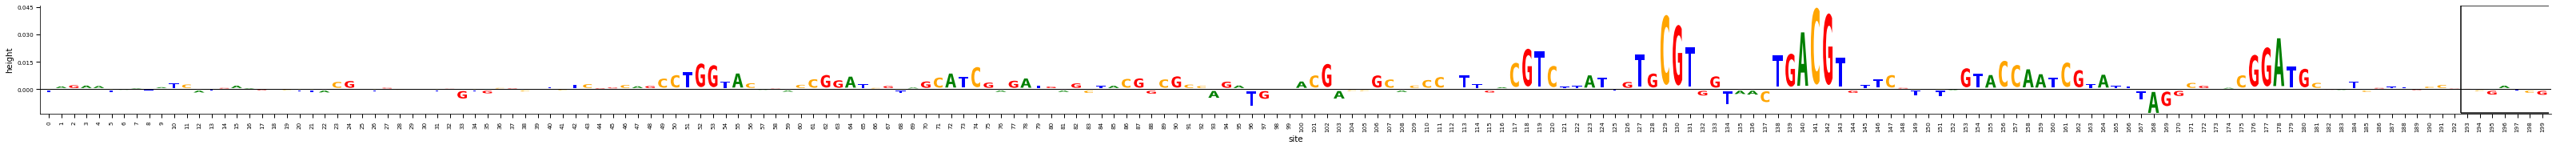

20211210_223825__729421__317::hmc__sknsh__0


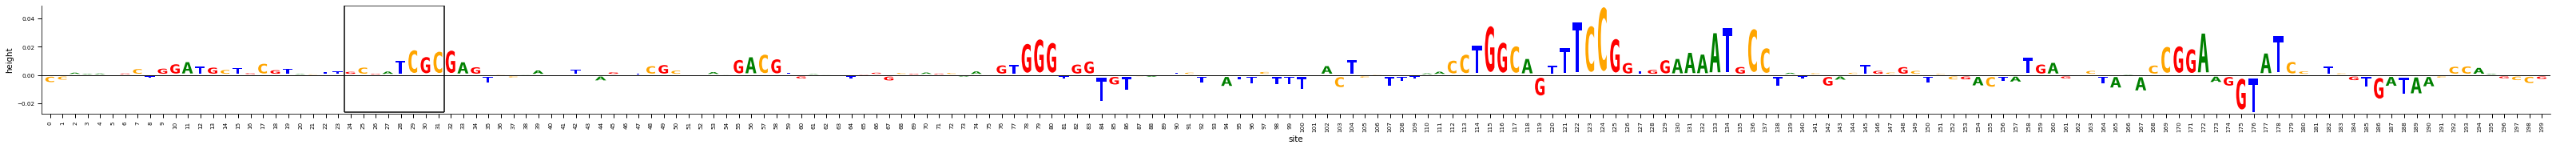

20211210_223825__729421__318::hmc__sknsh__0


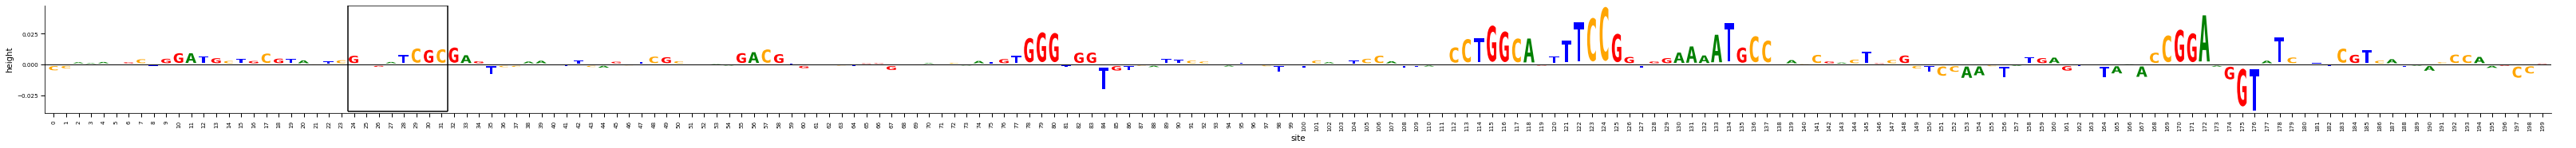

20211210_223938__220016__78::hmc__sknsh__0


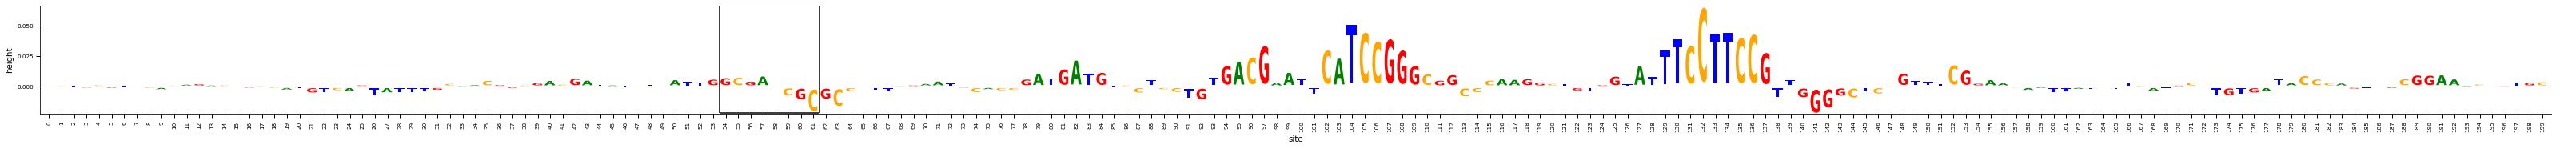

20211207_141610__992334__736::sa__sknsh__0


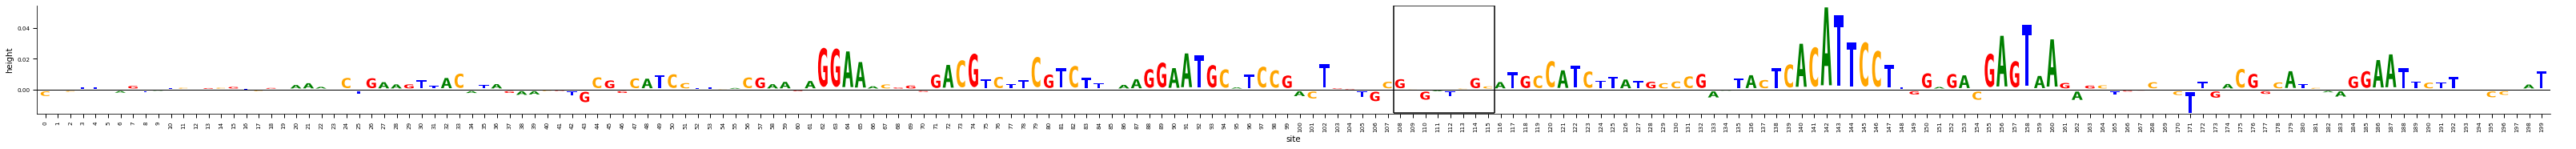

20211207_141610__992334__1375::sa__sknsh__0


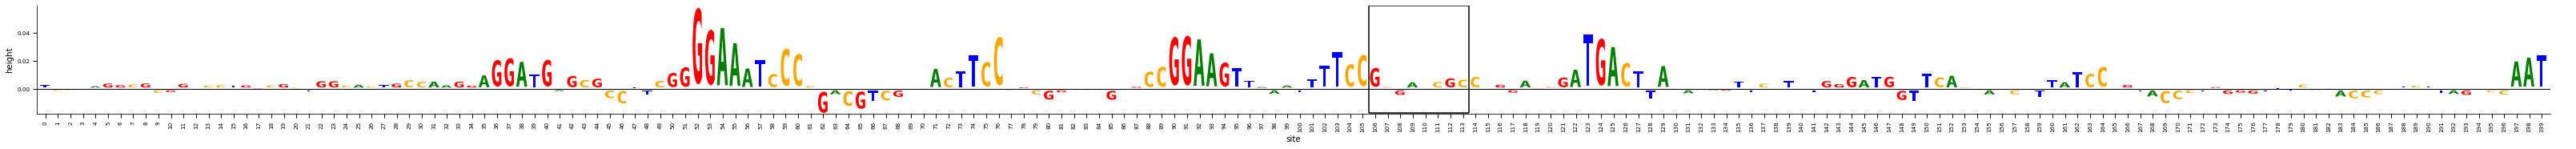

20211207_141610__992334__3139::sa__sknsh__2


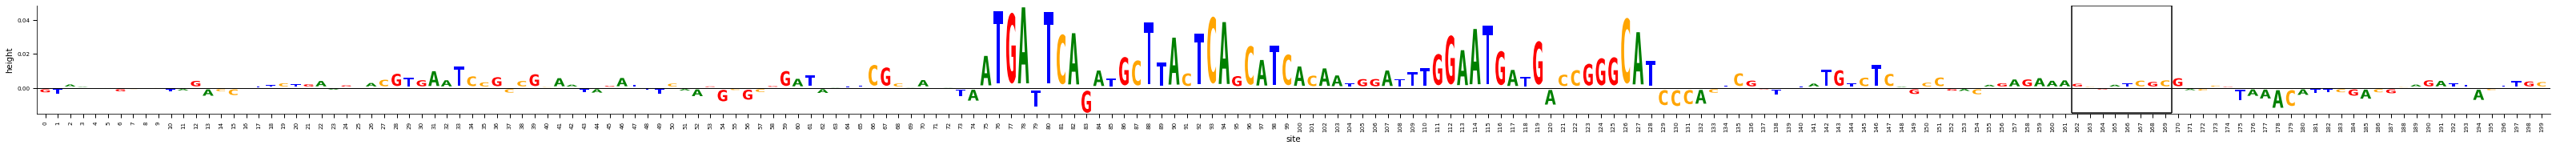

20211207_141610__992334__4099::sa__sknsh__3


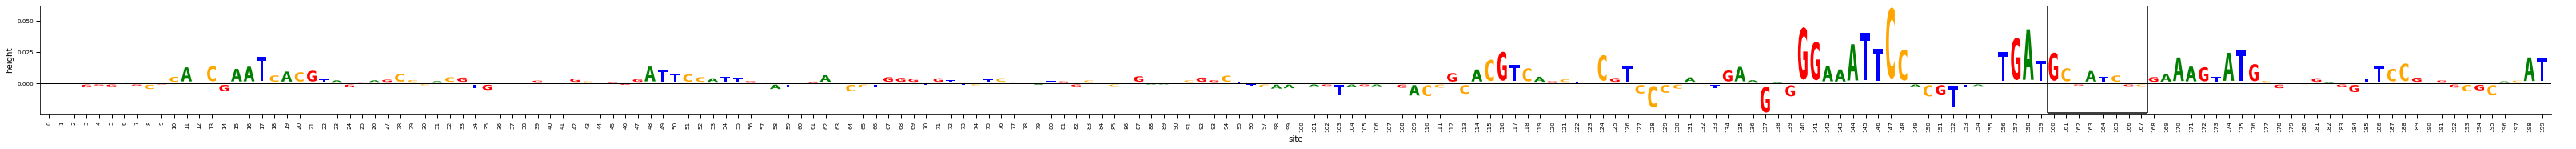

20211207_141610__992334__5933::sa__sknsh__4


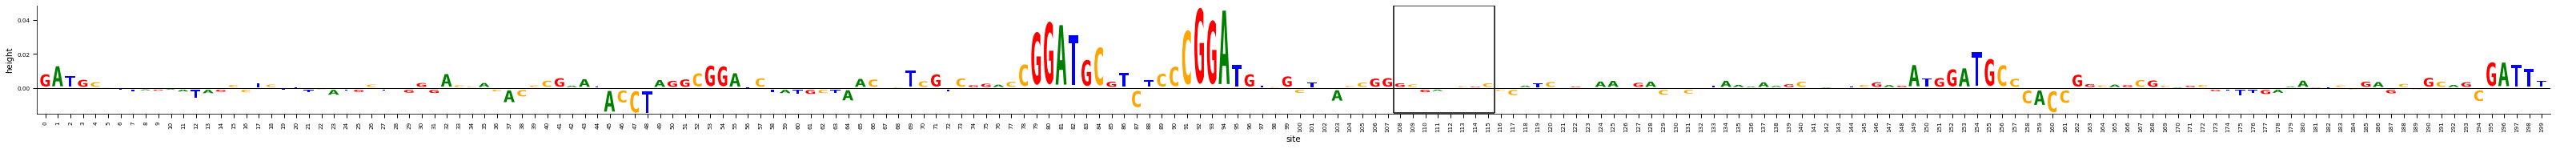

20211207_152258__777391__2937::sa__sknsh__1


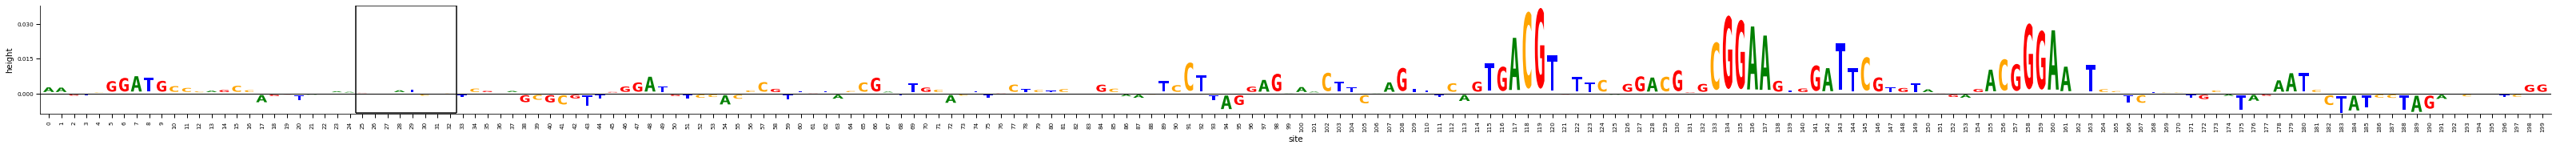

20211207_163007__848589__1775::sa__sknsh__0


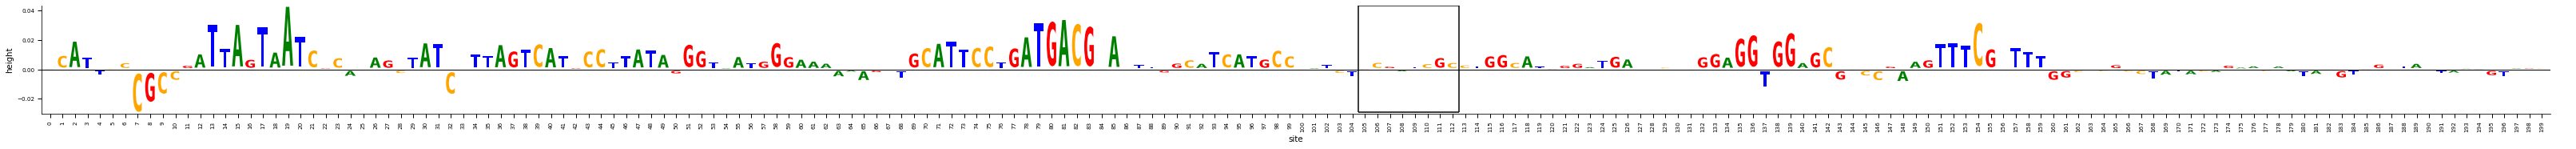

20211207_163007__848589__4773::sa__sknsh__3


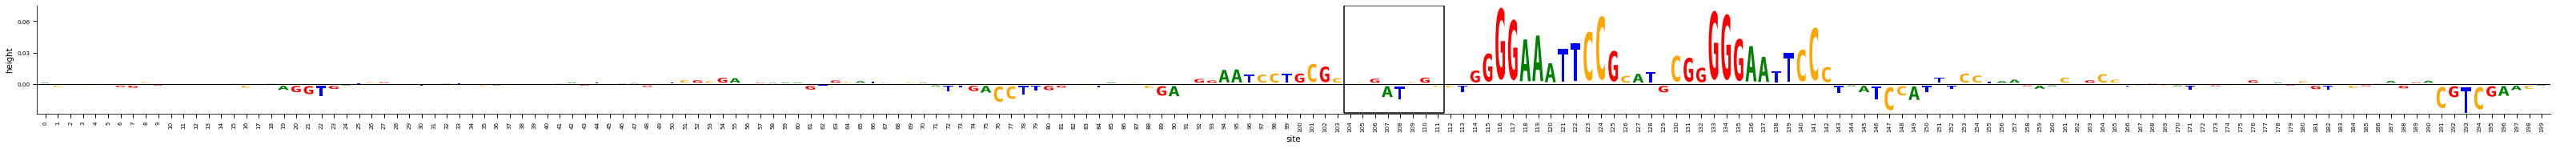

20211207_163007__848589__5087::sa__sknsh__4


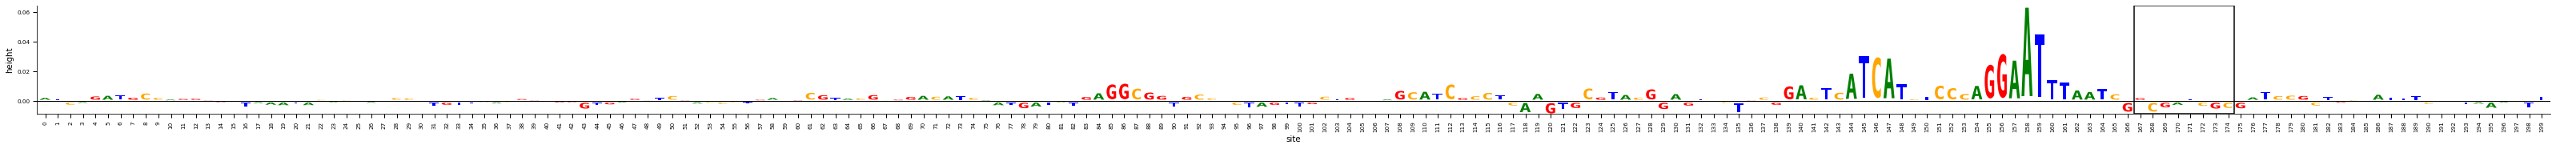

20211207_163007__848589__6619::sa__sknsh__5


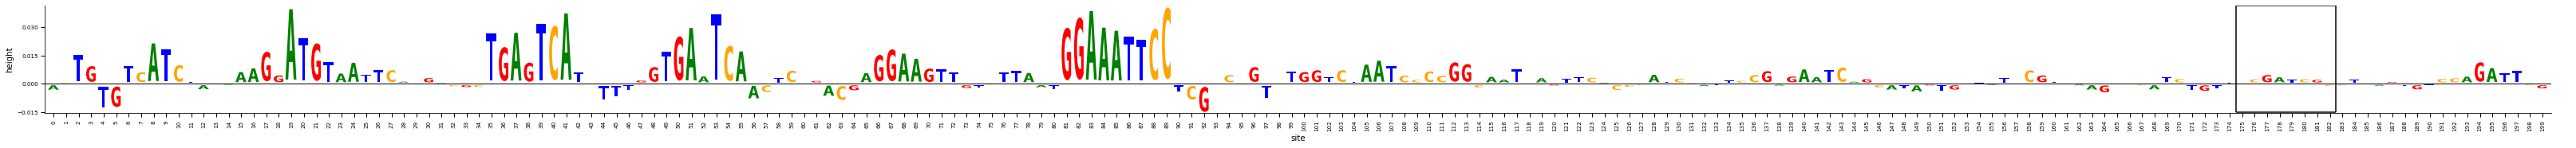

20211207_175000__383007__3169::sa__sknsh__2


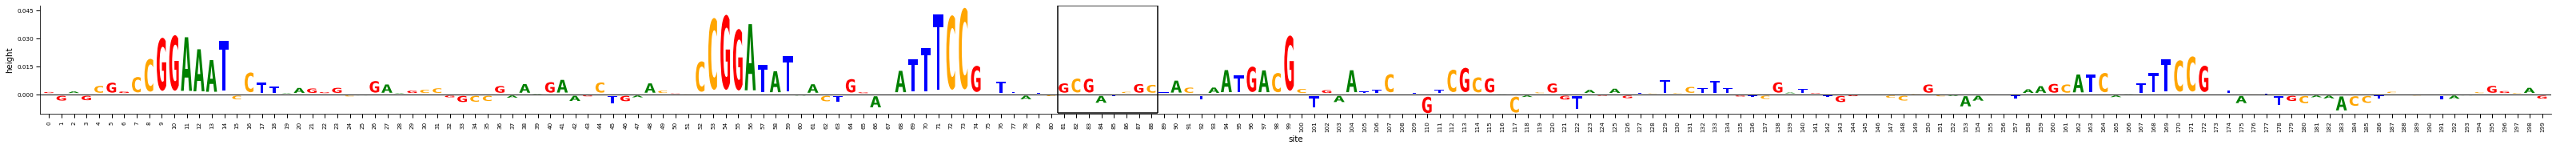

20211207_185623__627393__2715::sa__sknsh__1


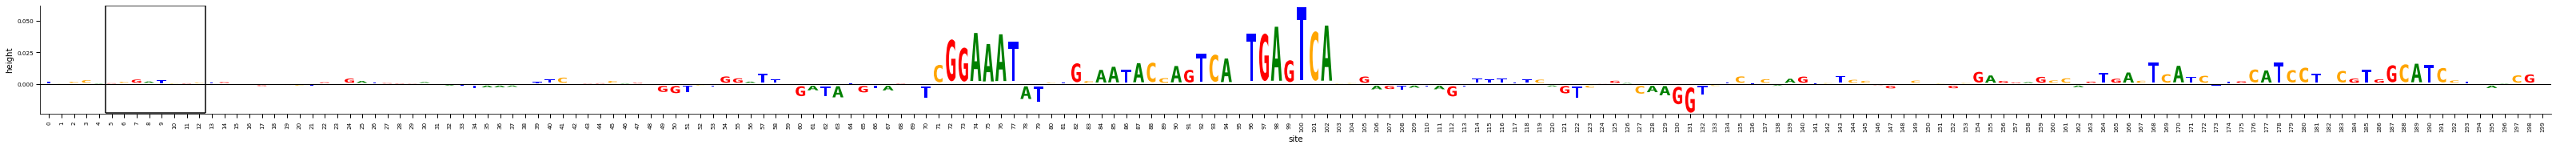

20211207_185623__627393__4945::sa__sknsh__3


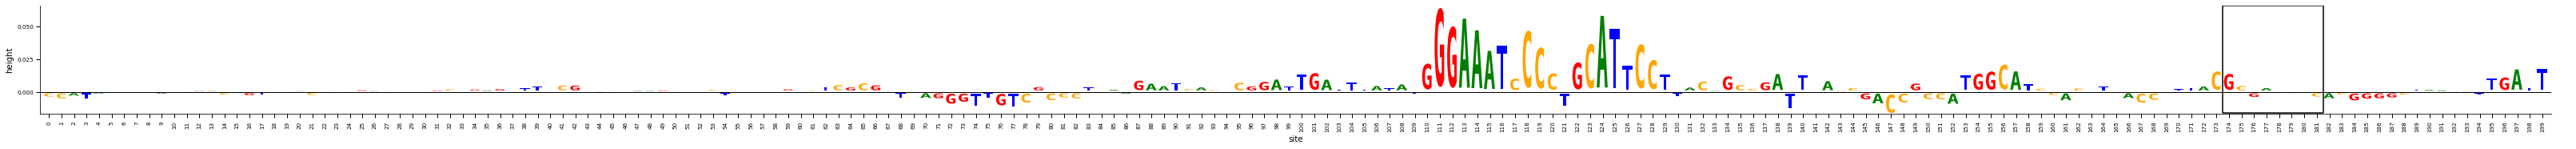

20211210_195146__778189__1150::sa_uc__sknsh__0


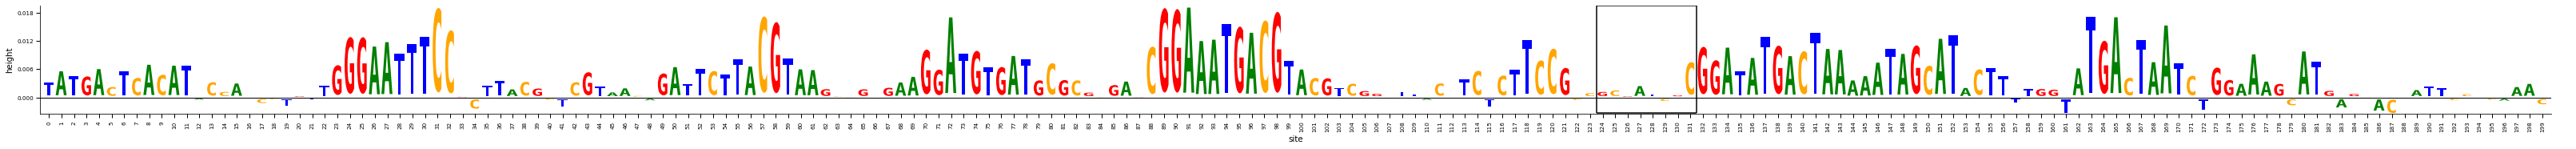

20211210_205149__971255__1223::sa_uc__sknsh__0


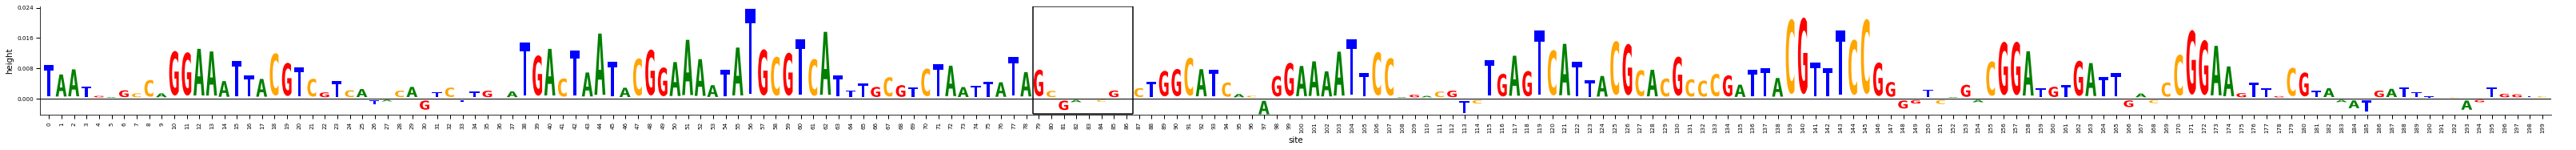

20211213_141412__444669__252::hmc__hepg2__0


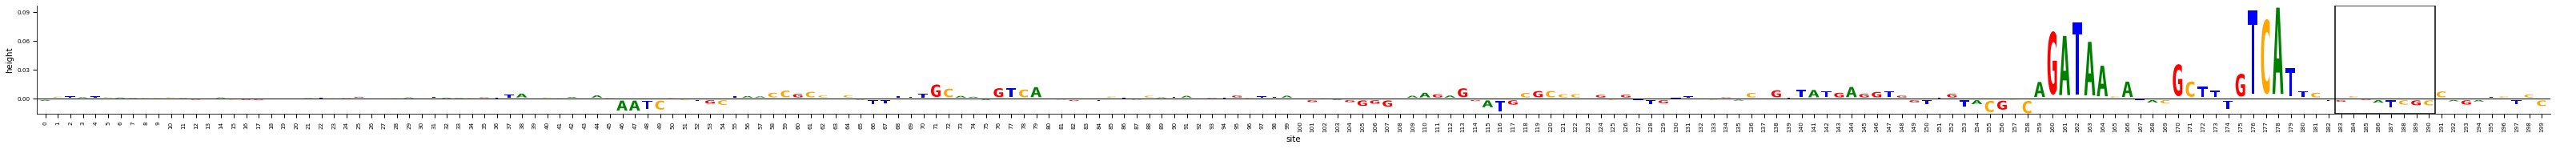

20211213_141525__841365__109::hmc__hepg2__0


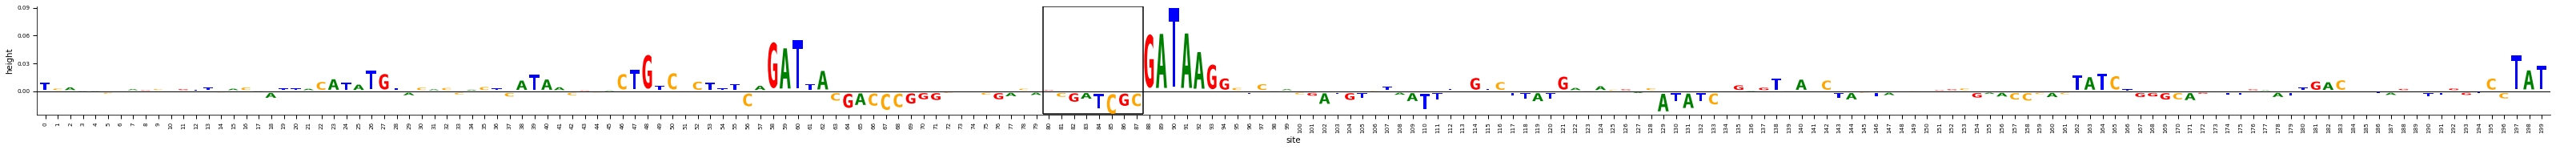

20211213_141901__715602__194::hmc__hepg2__0


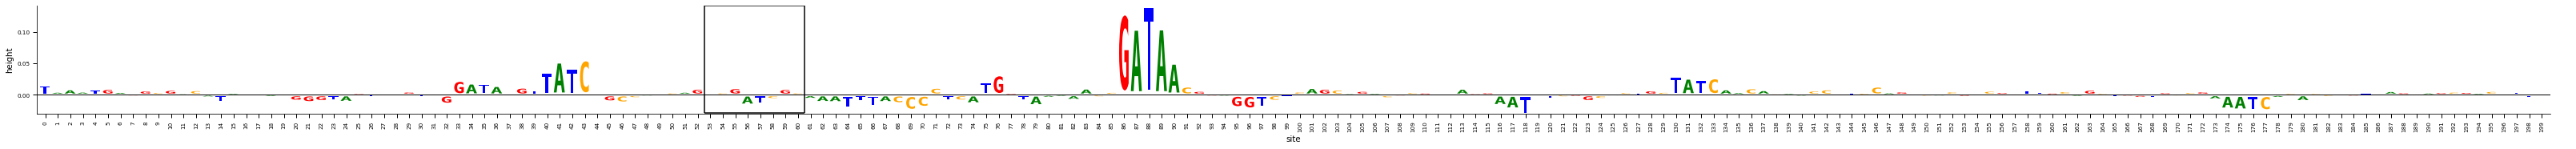

20211213_142614__766736__20::hmc__sknsh__0


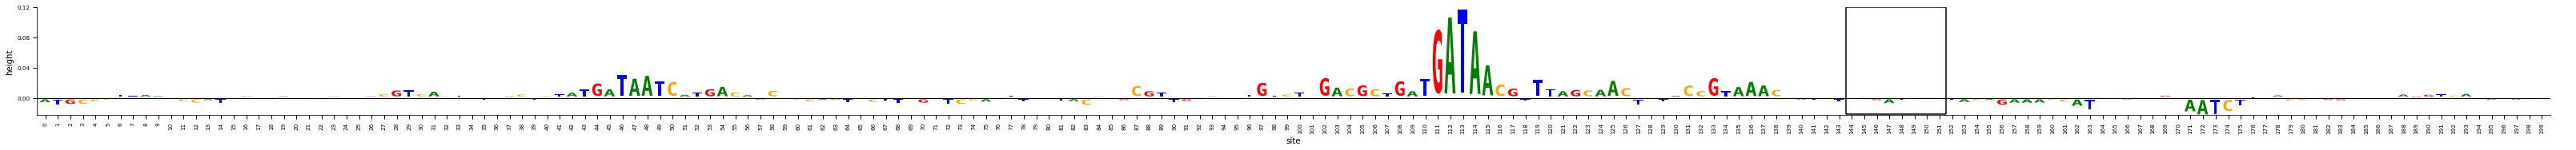

20211206_25737__87493515__72::al__hepg2__5


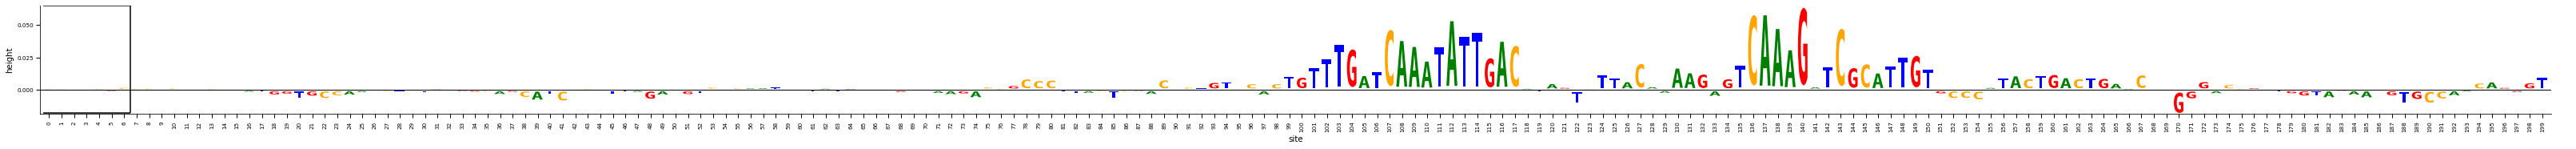

20211208_22639__44591335__58::al__hepg2__2


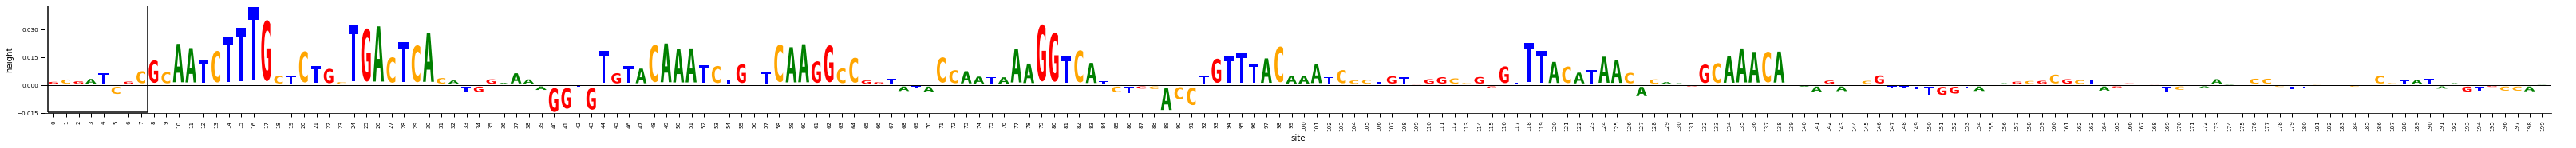

20211208_32239__17214778__94::al__hepg2__5


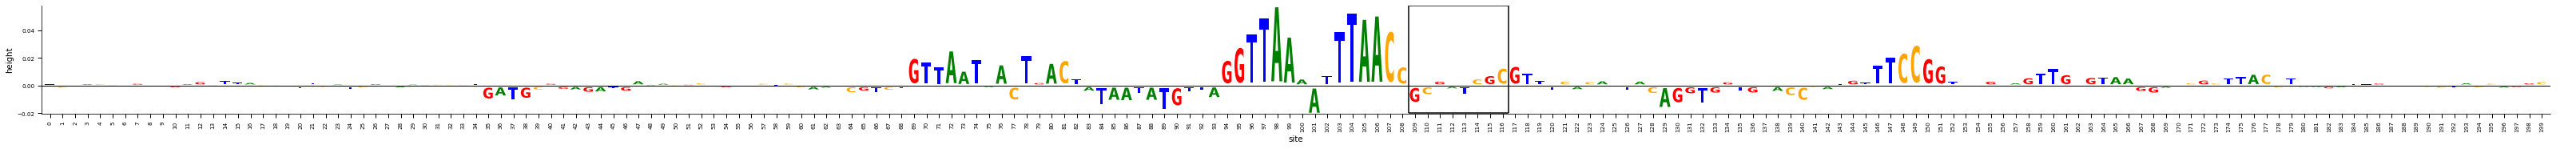

20211206_221956__59439361__2253::al__k562__0


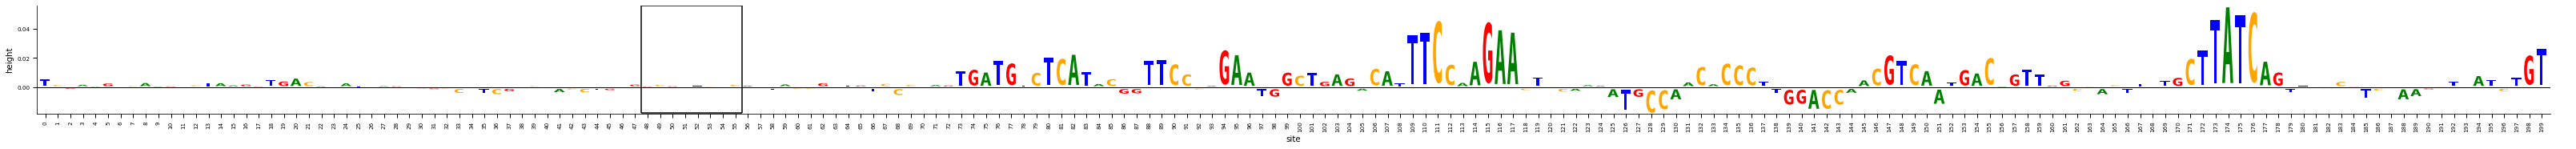

20211206_221956__59439361__3286::al__k562__0


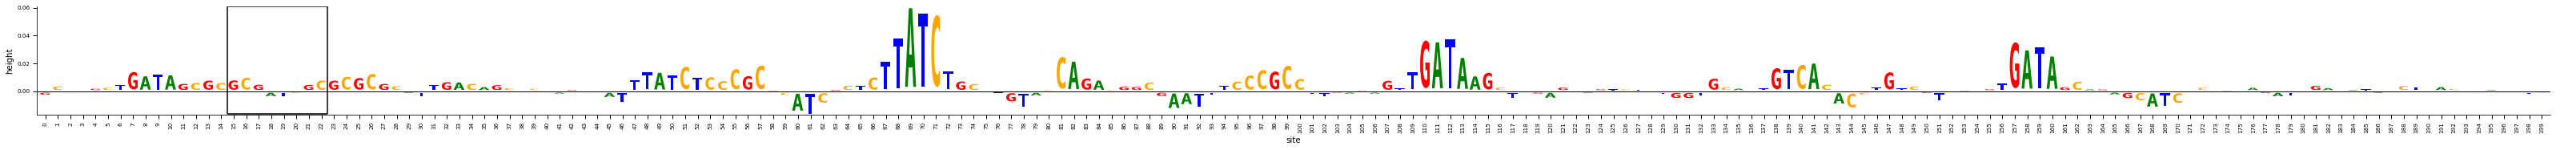

20211208_2954__56294947__13::al__k562__3


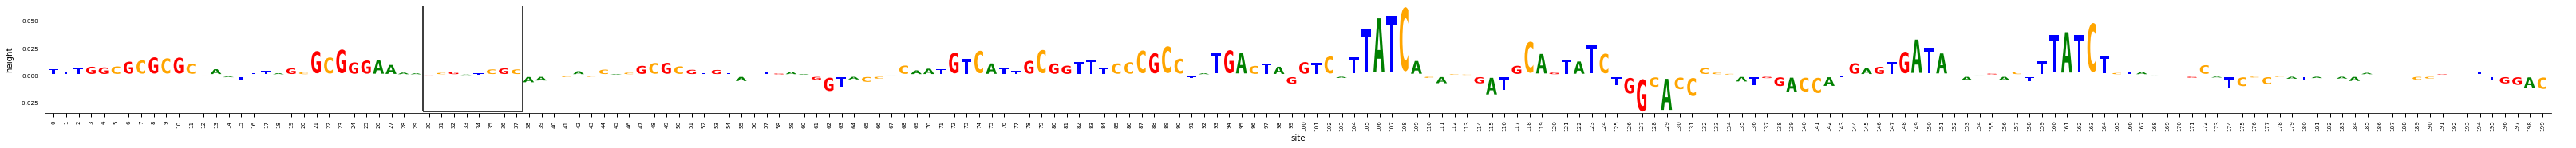

20211208_52650__84057002__83::al__sknsh__4


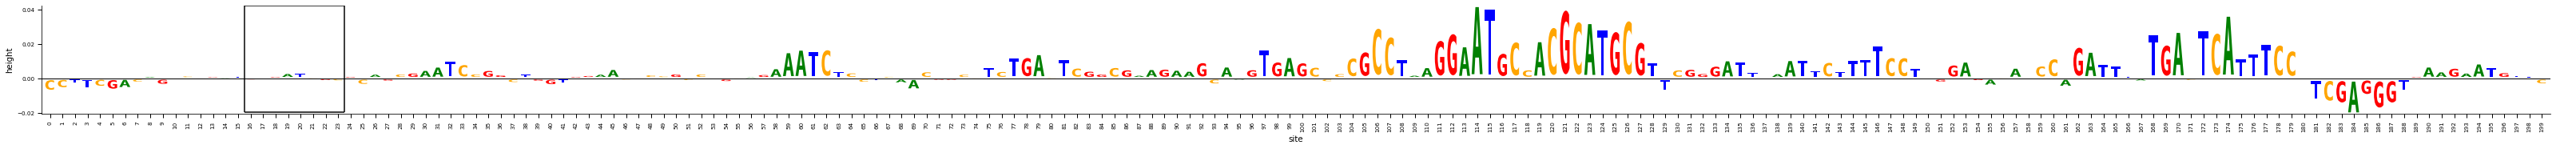

20211212_12620__229779__595::fsp__hepg2__0


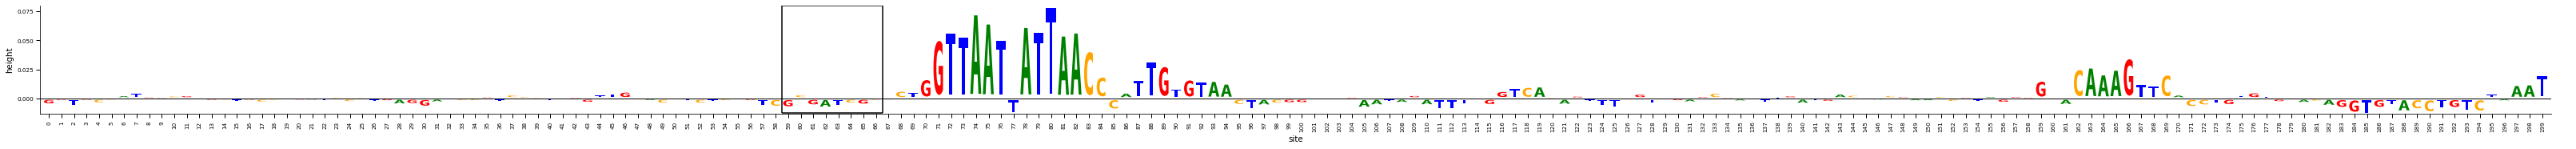

20211212_12620__229779__1708::fsp__hepg2__0


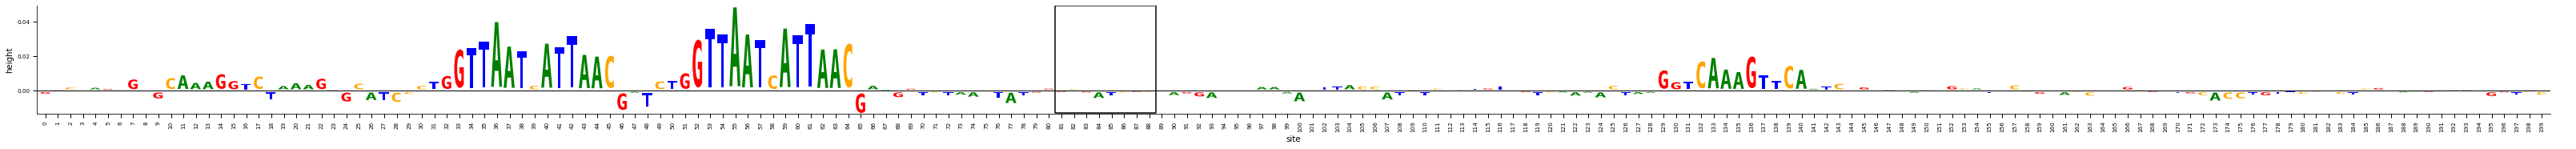

20211212_45907__313665__984::fsp__hepg2__2


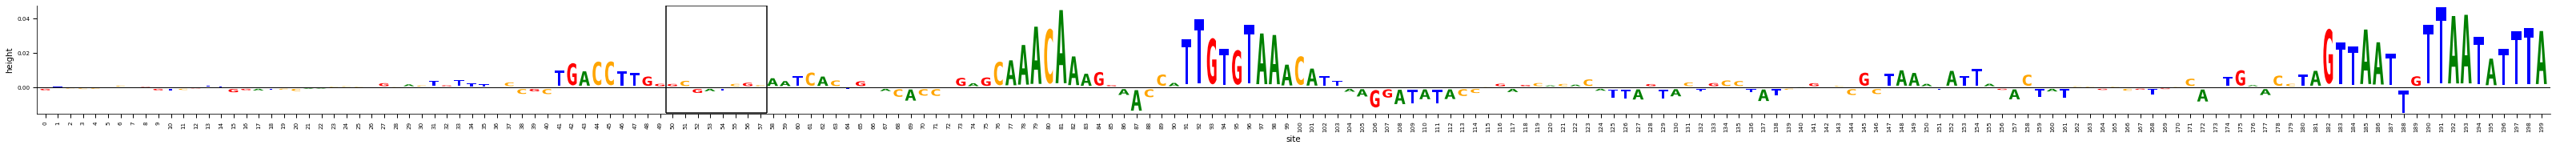

20211212_45907__313665__1449::fsp__hepg2__4


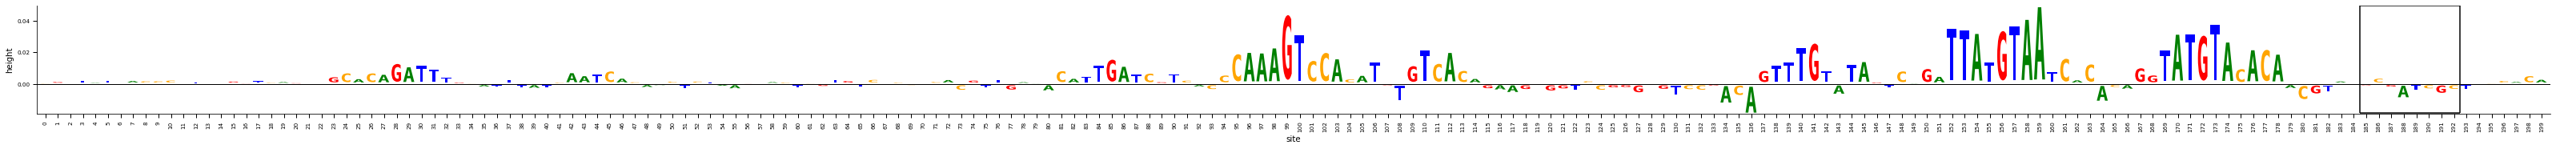

20211212_45907__313665__1559::fsp__hepg2__5


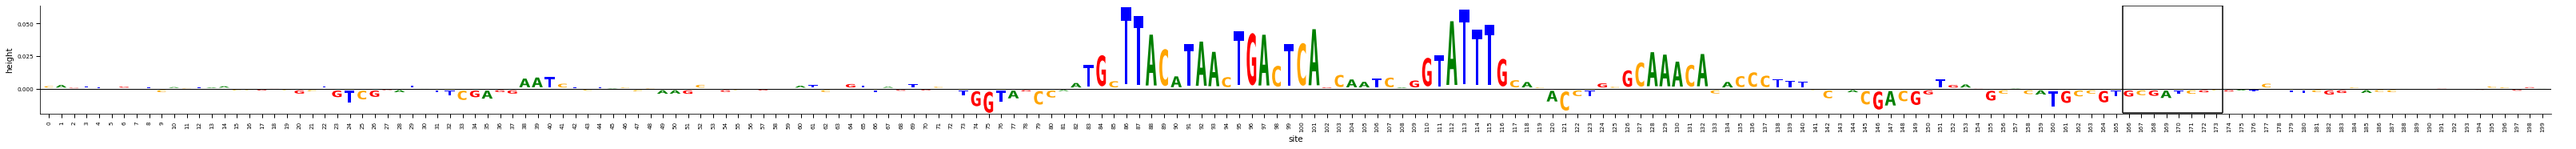

20211212_52639__969454__1019::fsp__hepg2__3


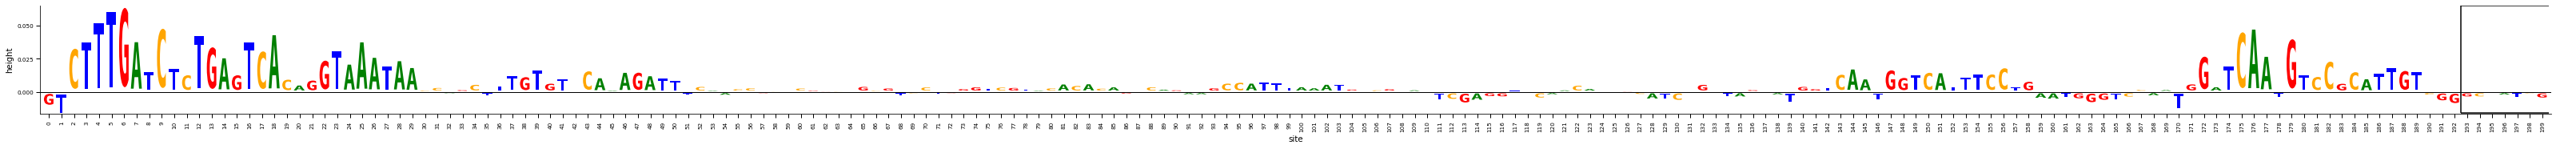

20211212_52639__969454__1286::fsp__hepg2__4


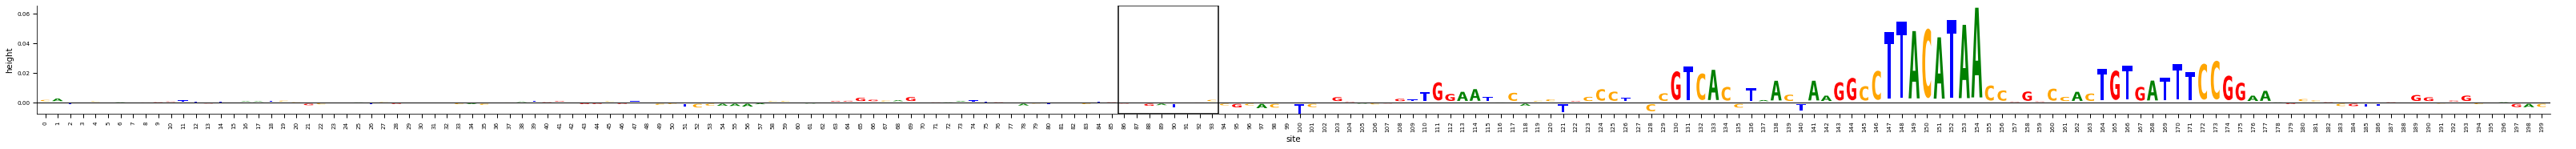

20211212_52639__969454__1688::fsp__hepg2__5


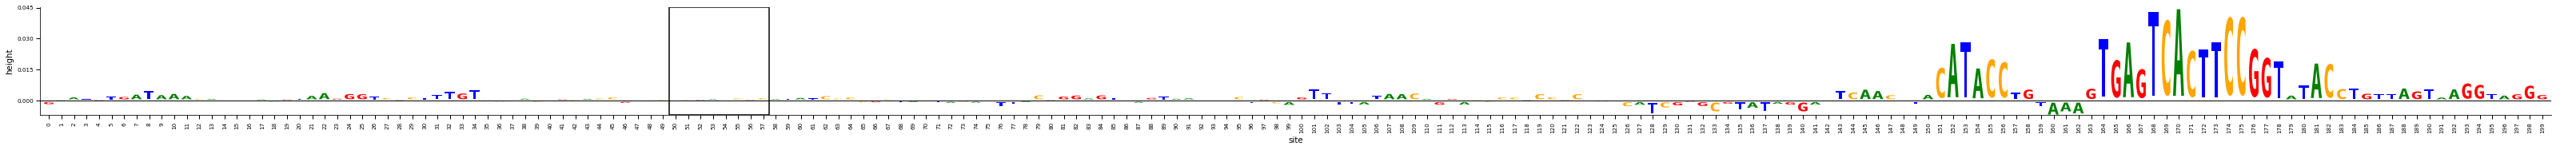

20211212_55149__346635__496::fsp__hepg2__0


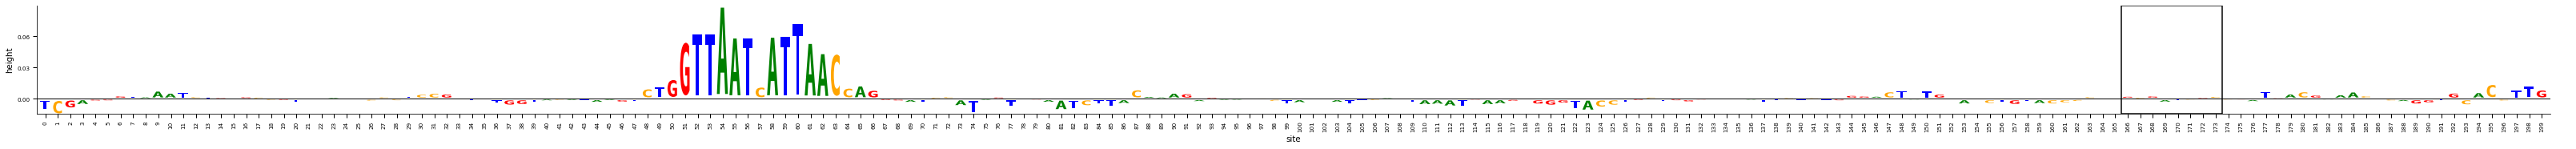

20211212_55149__346635__554::fsp__hepg2__1


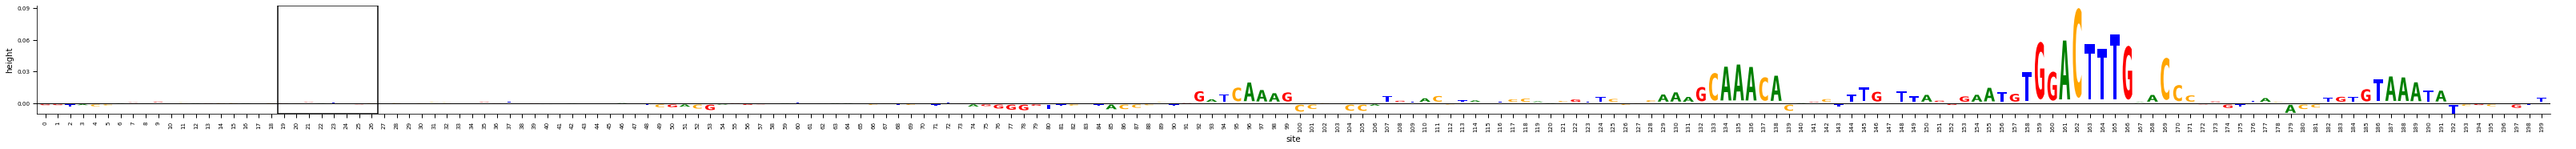

20211212_55149__346635__933::fsp__hepg2__2


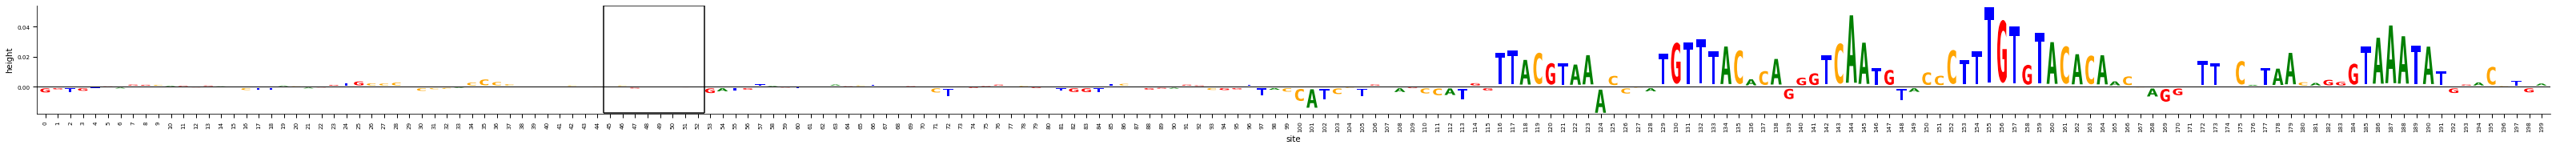

20211212_55149__346635__1250::fsp__hepg2__4


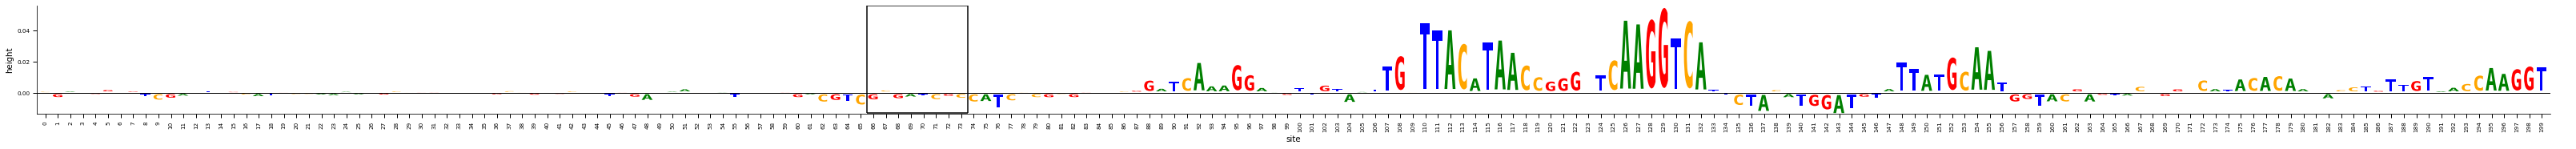

20211212_55149__346635__1343::fsp__hepg2__4


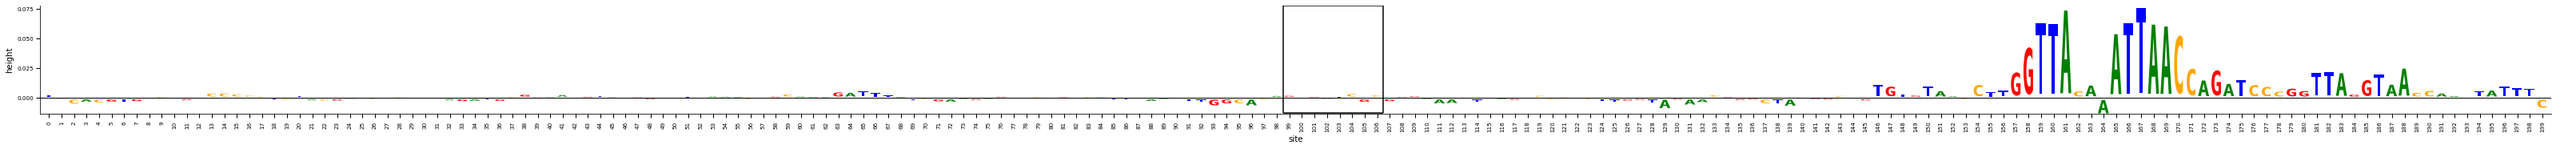

20211212_61436__944763__696::fsp__hepg2__1


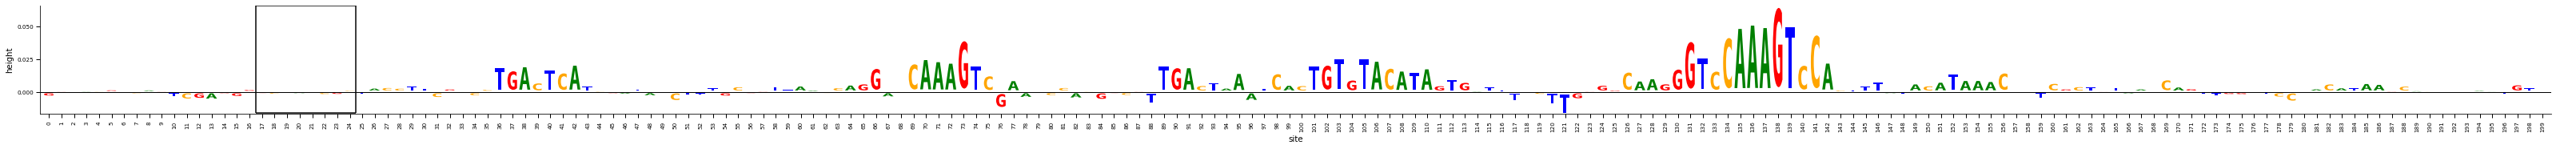

20211212_10357__323391__918::fsp__k562__0


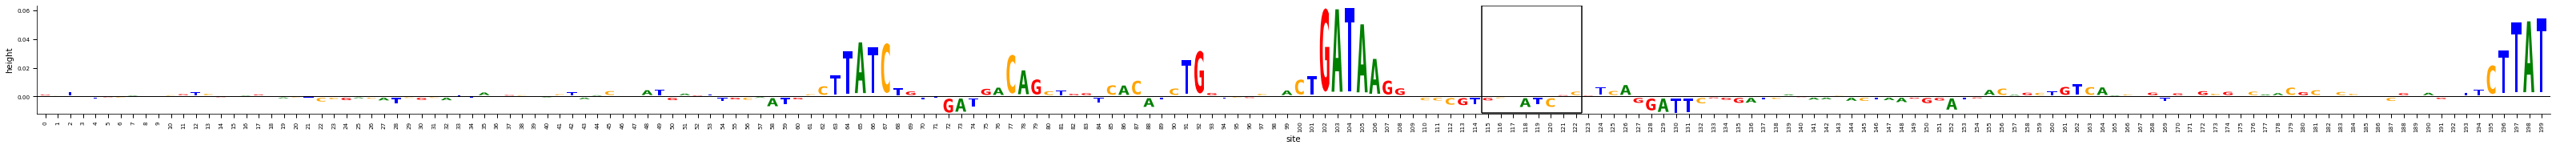

20211212_10357__323391__1365::fsp__k562__0


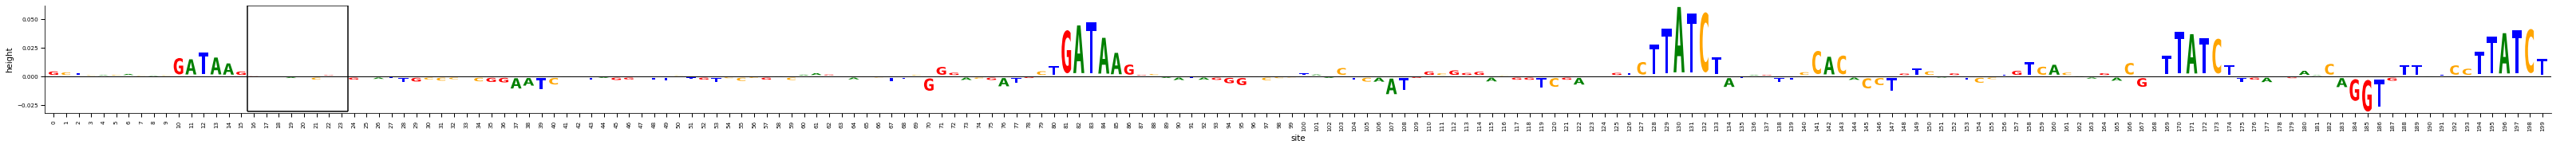

20211212_10357__323391__1561::fsp__k562__0


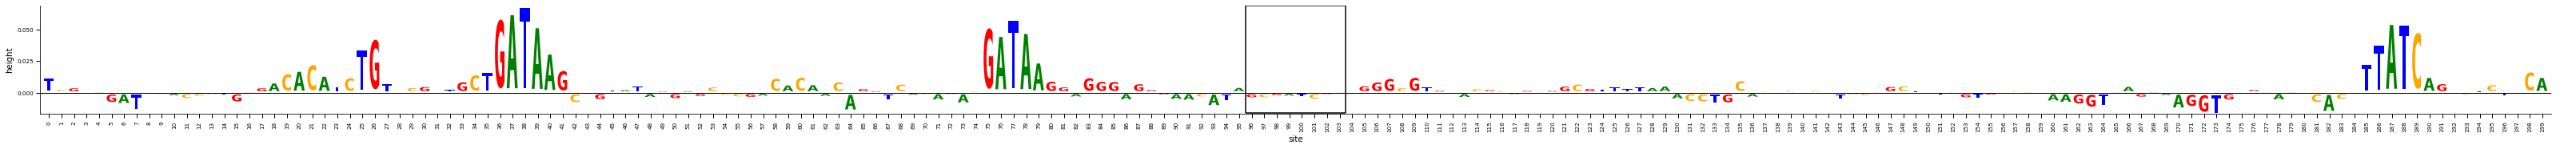

20211212_22207__477844__114::fsp__k562__0


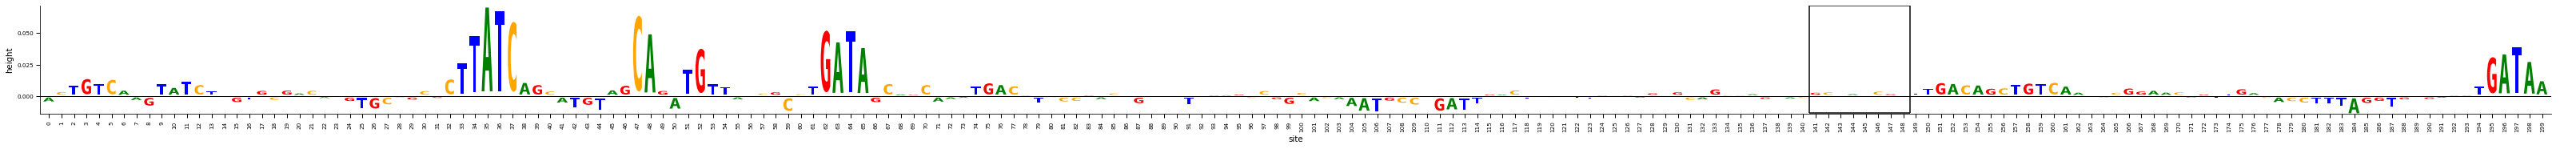

20211212_22207__477844__407::fsp__k562__0


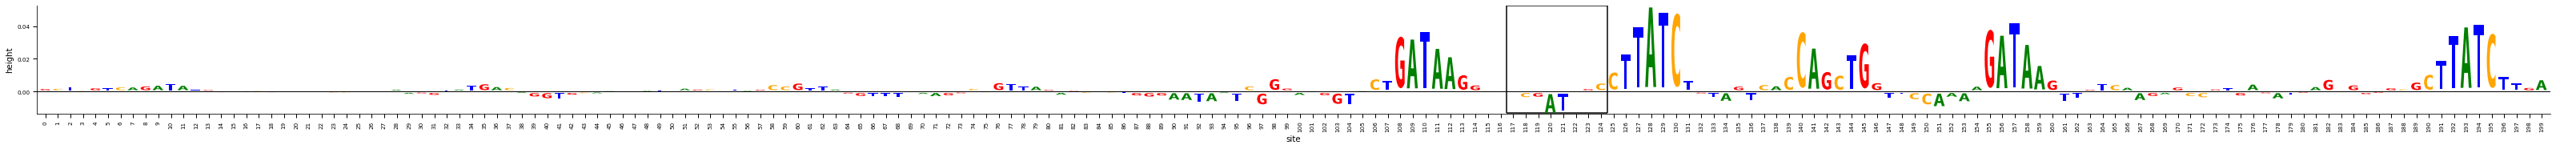

20211212_22207__477844__1481::fsp__k562__4


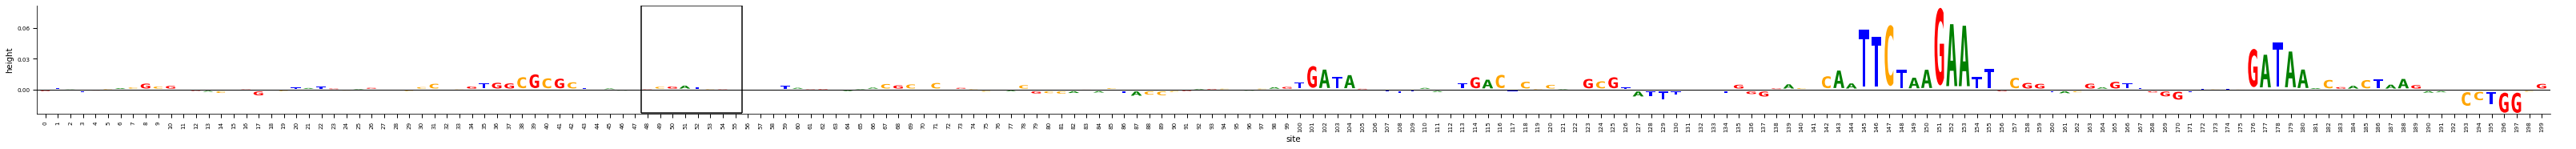

20211212_22207__477844__1577::fsp__k562__5


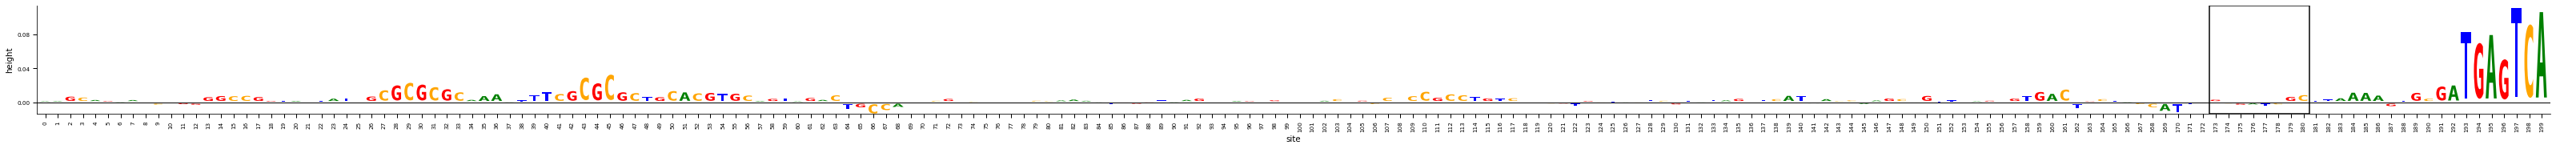

20211212_24754__730114__751::fsp__k562__2


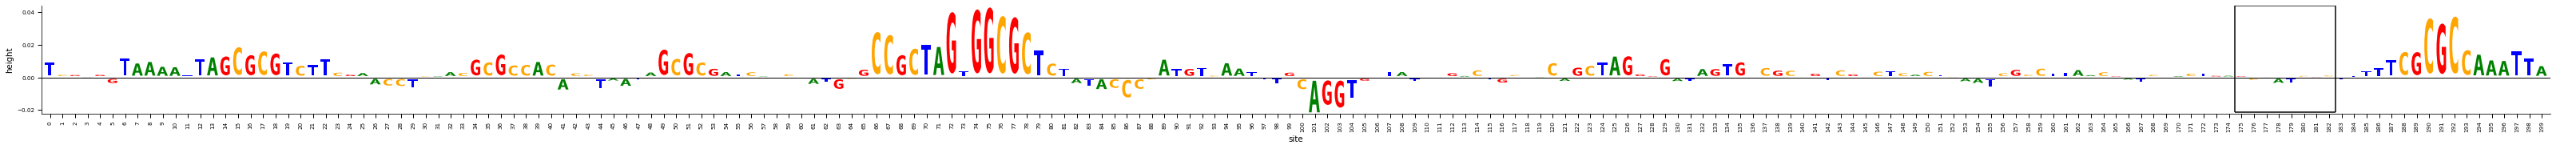

20211212_24754__730114__1117::fsp__k562__3


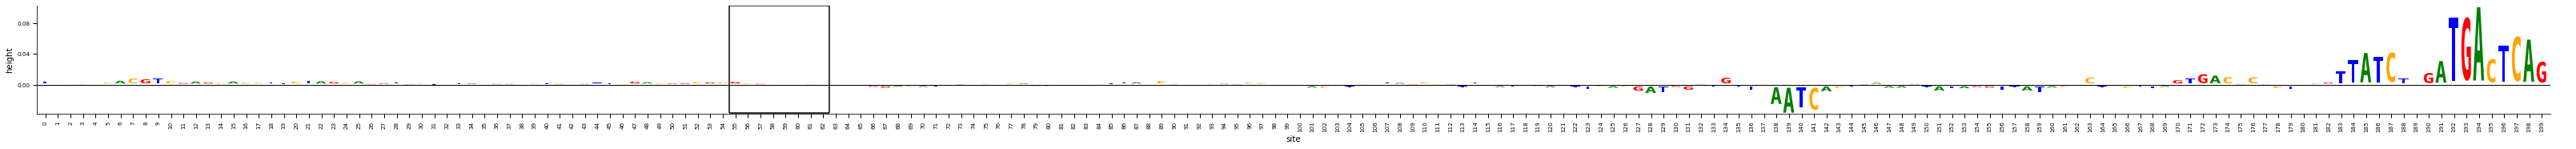

20211212_24754__730114__1510::fsp__k562__5


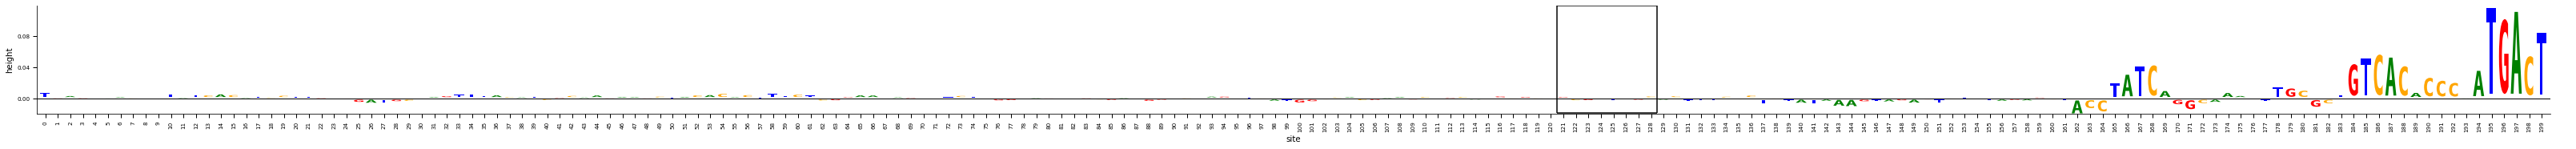

20211212_85225__619474__273::fsp__k562__0


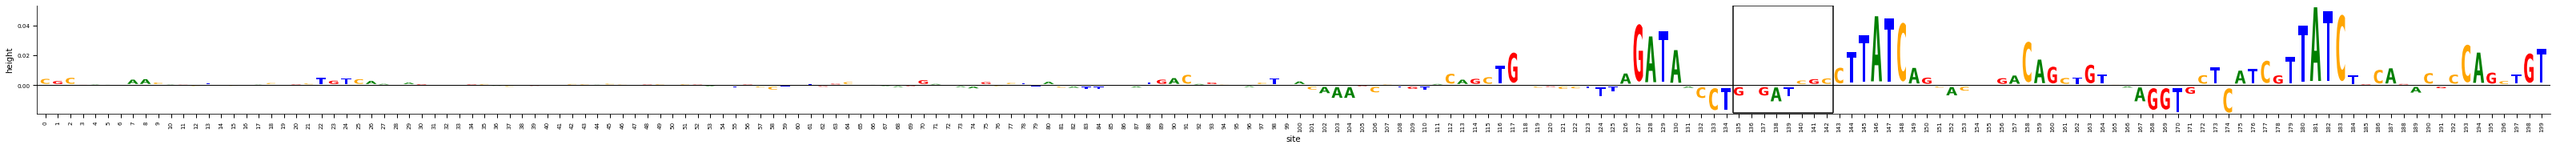

20211212_85225__619474__744::fsp__k562__1


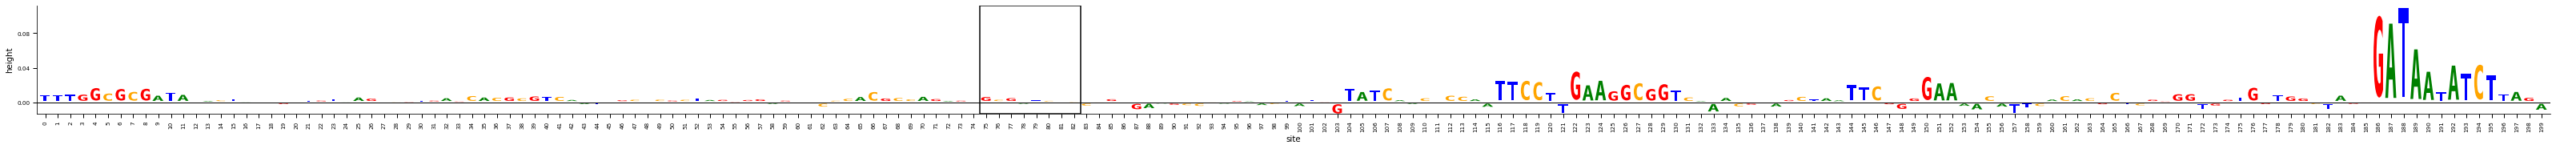

20211212_92818__893131__735::fsp__k562__1


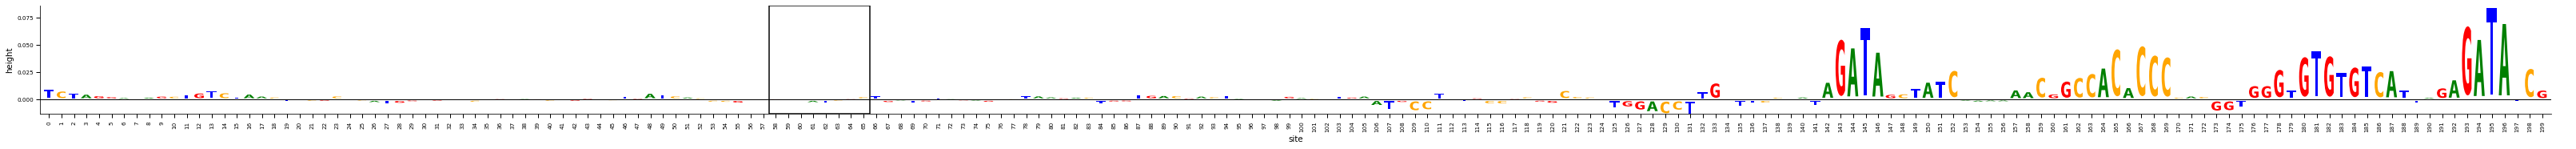

20211212_92818__893131__1466::fsp__k562__4


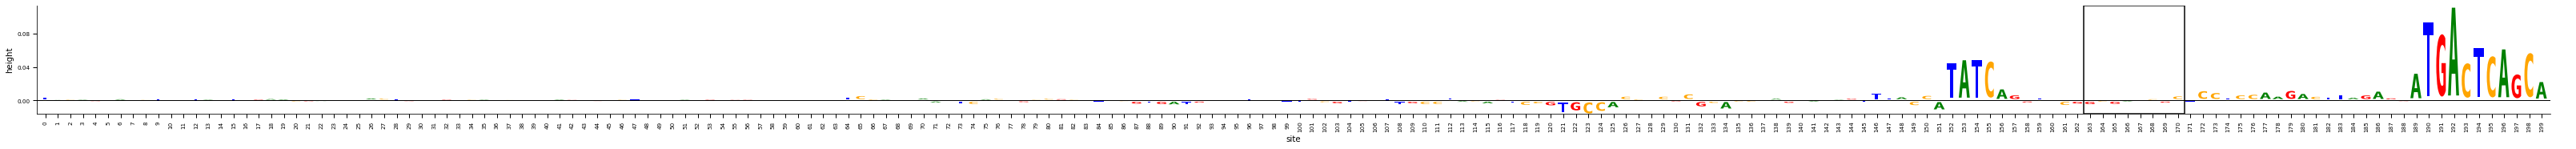

20211212_14909__942569__555::fsp__sknsh__0


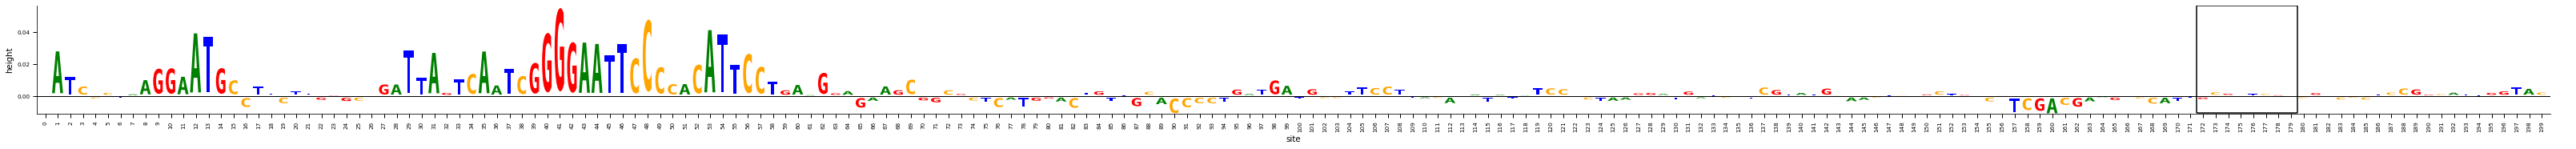

20211212_122659__199840__197::fsp__sknsh__0


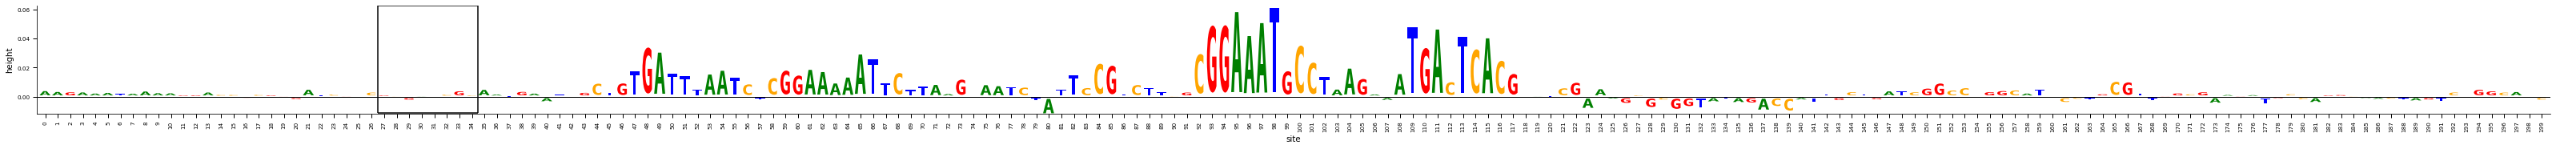

20211212_122659__199840__261::fsp__sknsh__0


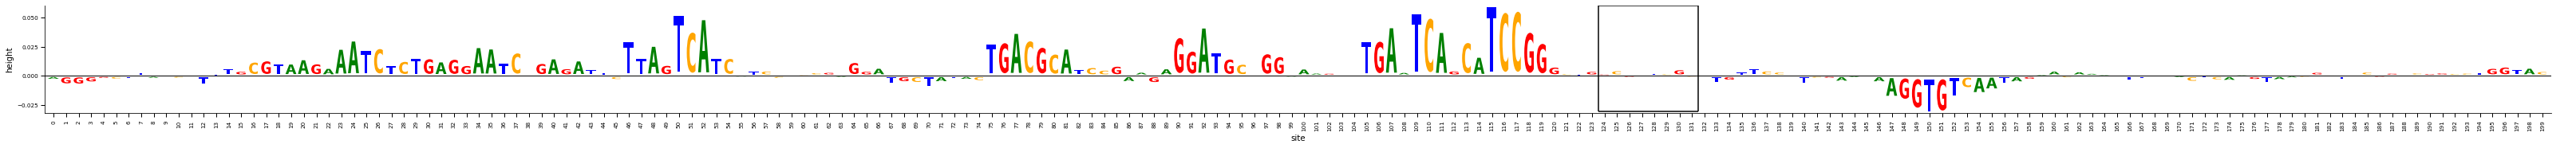

20211212_122659__199840__594::fsp__sknsh__1


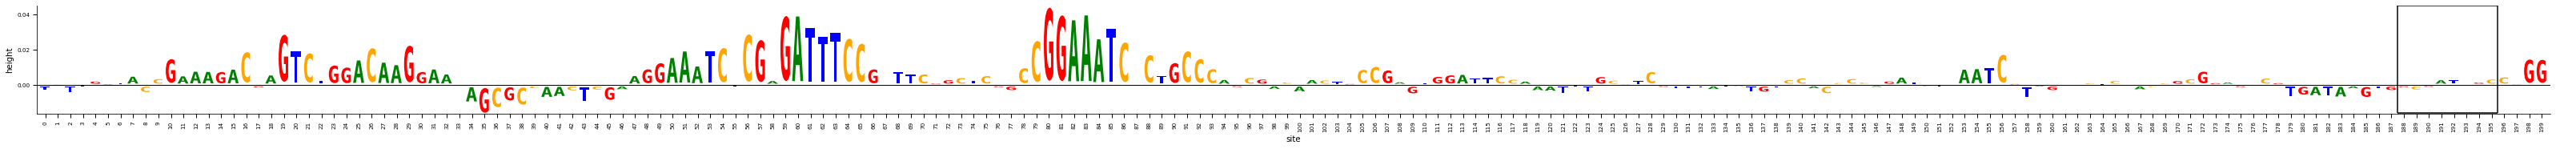

20211212_122659__199840__1204::fsp__sknsh__3


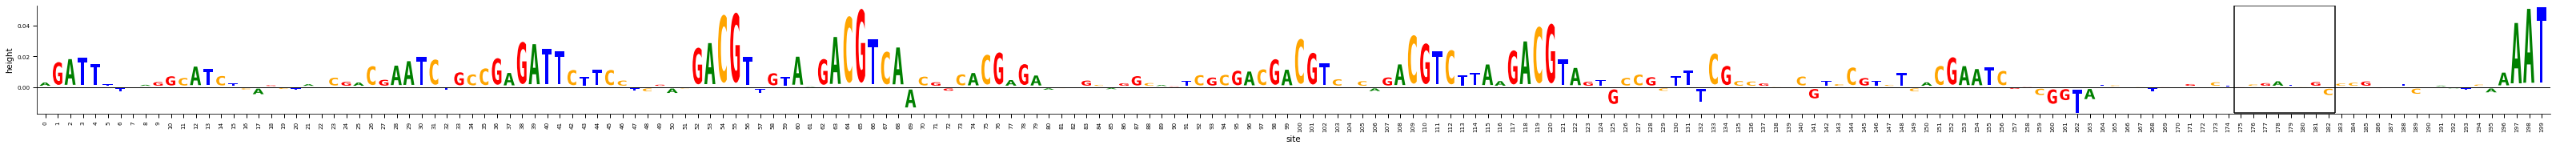

20211212_122659__199840__1397::fsp__sknsh__4


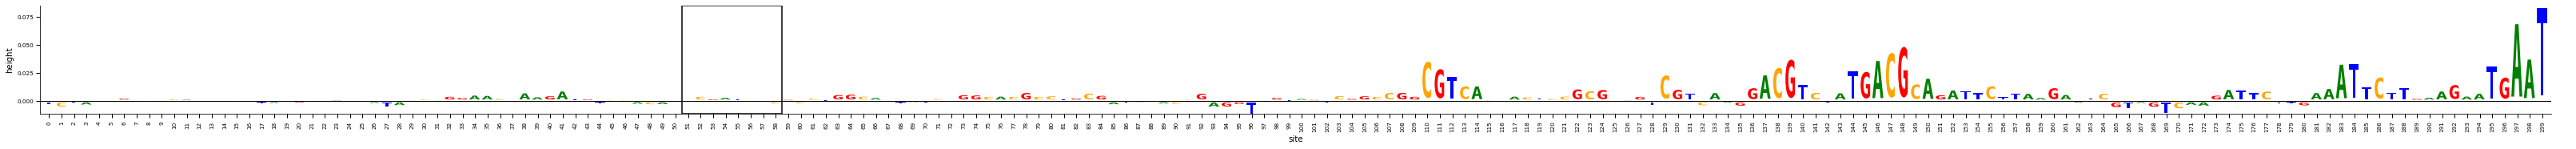

20211212_122659__199840__1520::fsp__sknsh__5


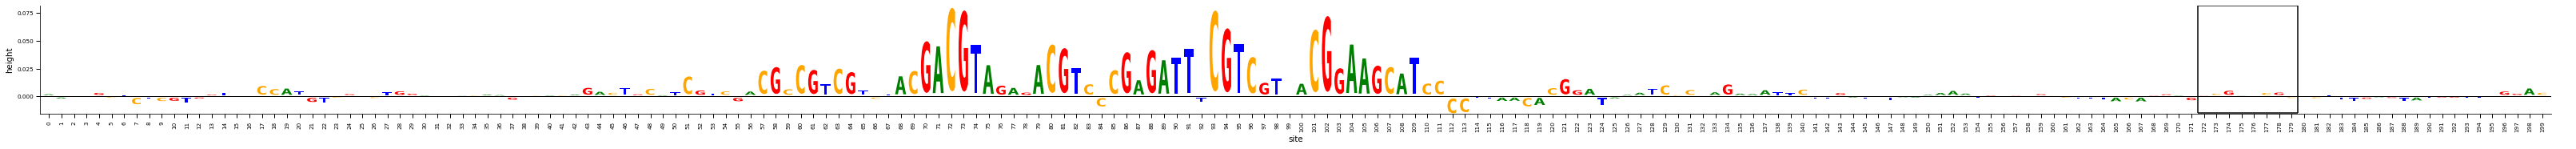

20211212_122659__199840__1578::fsp__sknsh__5


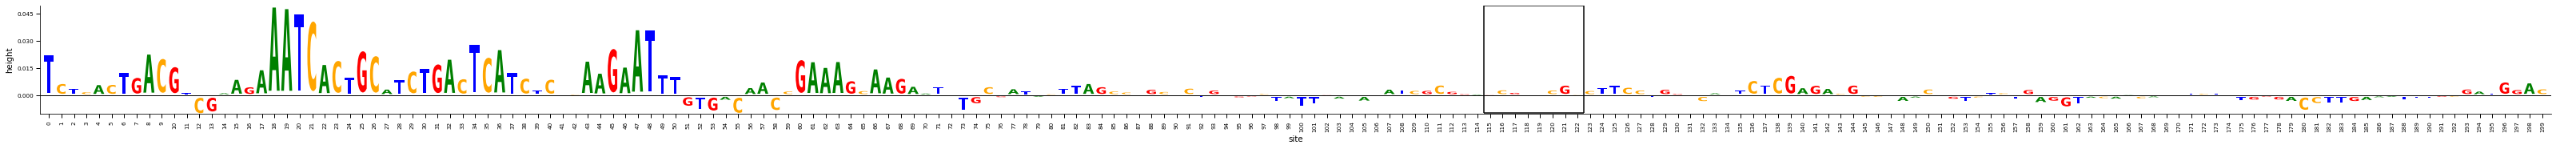

20211212_122659__199840__1696::fsp__sknsh__5


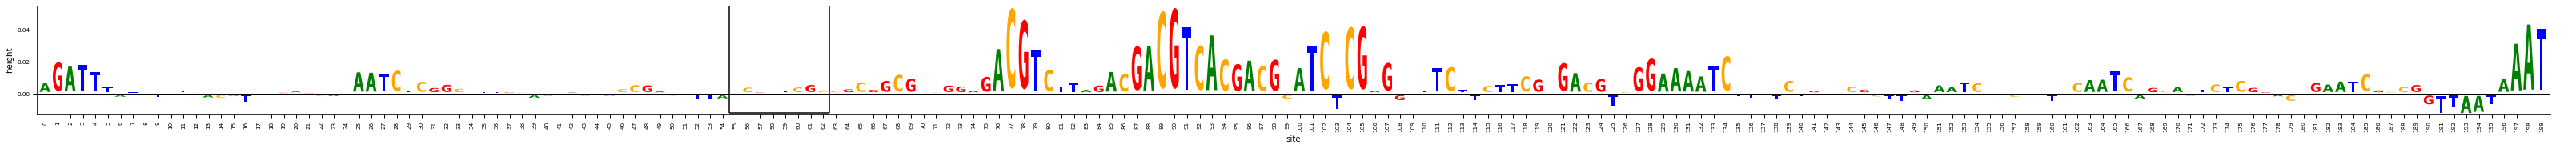

20211212_73316__958155__338::fsp__sknsh__0


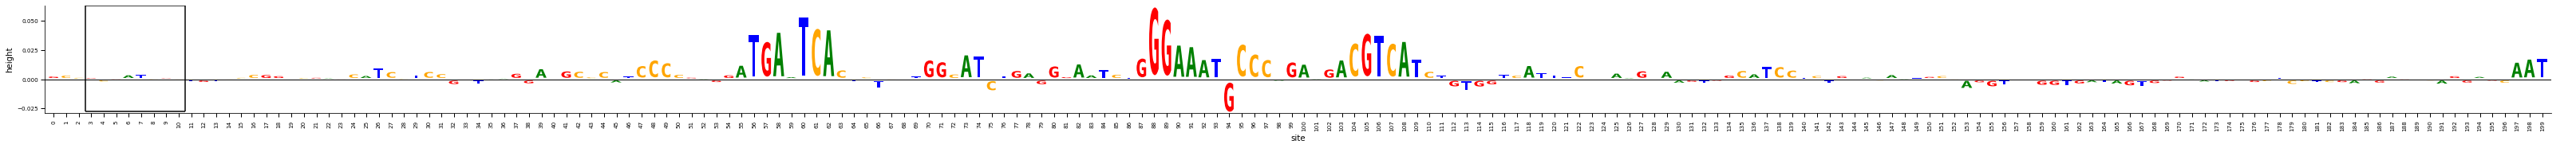

20211212_73316__958155__795::fsp__sknsh__2


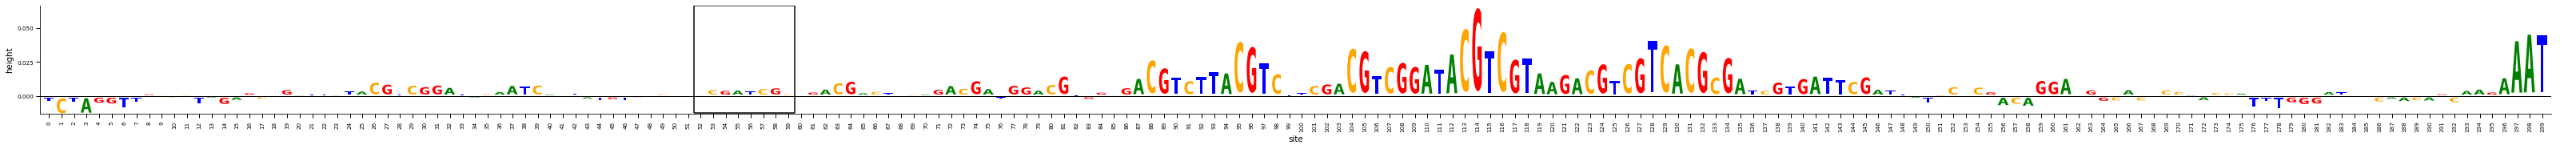

20211212_73316__958155__1430::fsp__sknsh__4


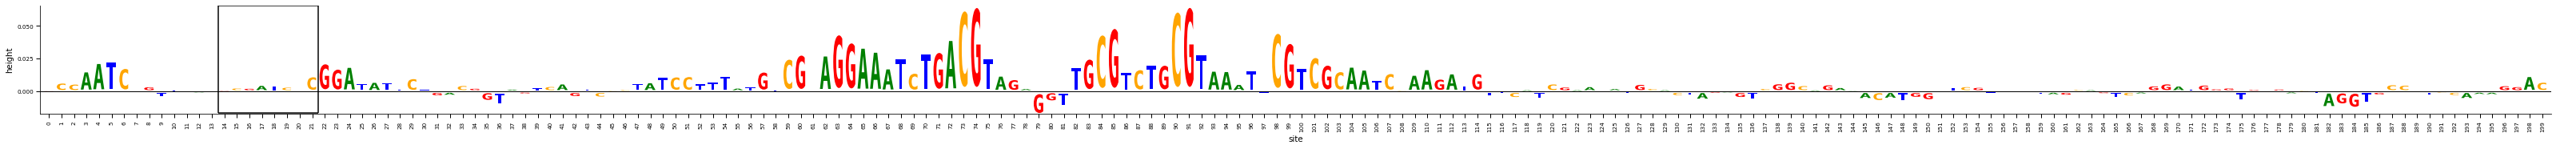

20211212_75659__621411__831::fsp__sknsh__2


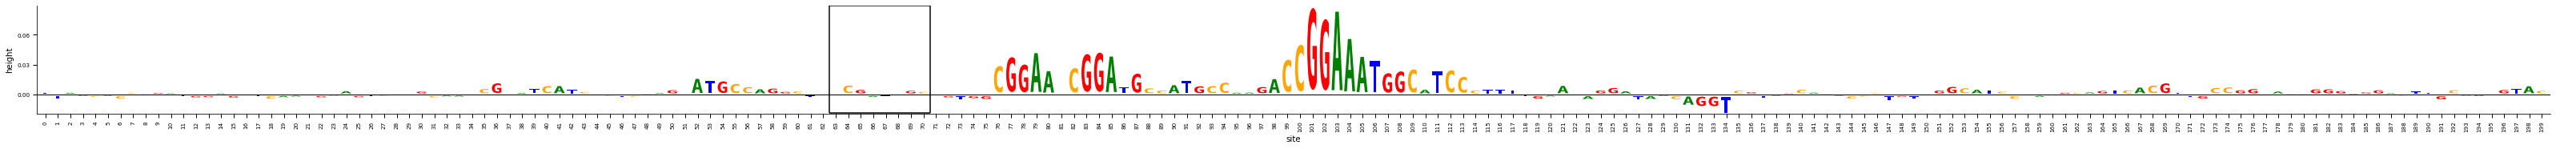

20211212_82245__817810__333::fsp__sknsh__0


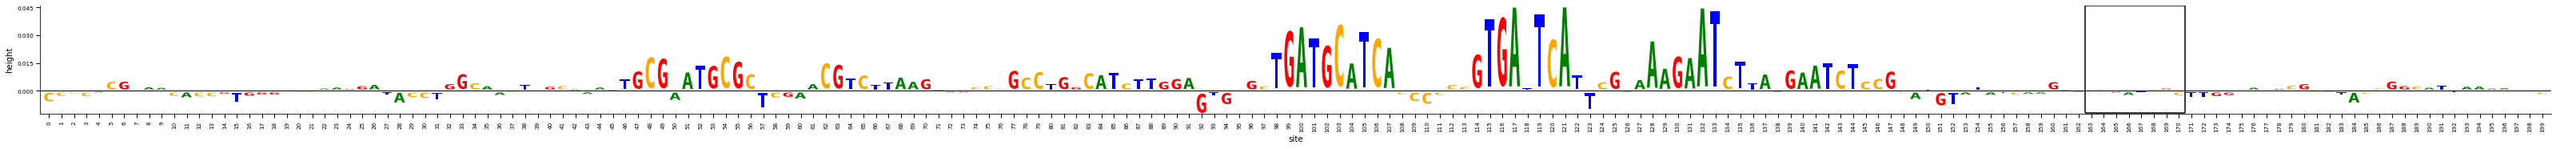

20211212_82245__817810__731::fsp__sknsh__1


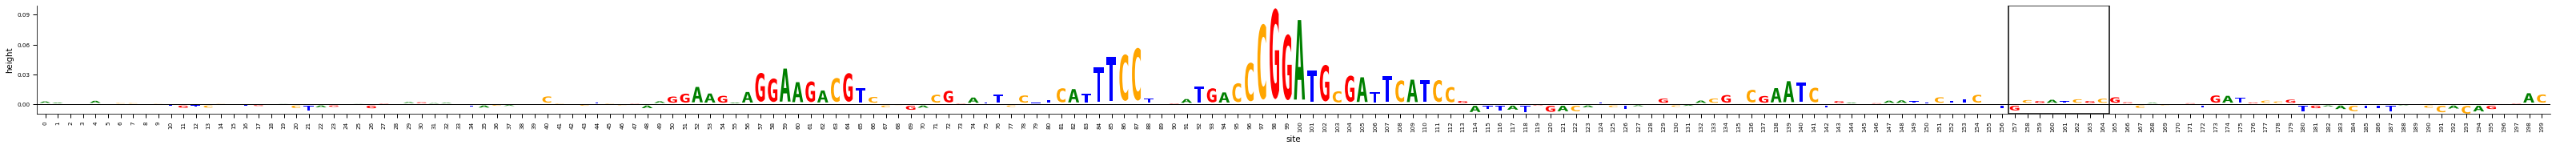

20211212_82245__817810__1007::fsp__sknsh__3


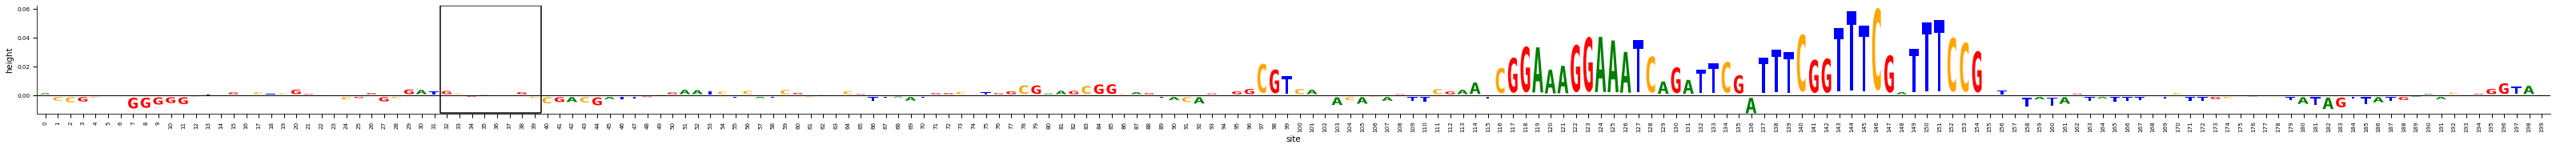

20211214_100033__420816__864::sa_rep__hepg2__0


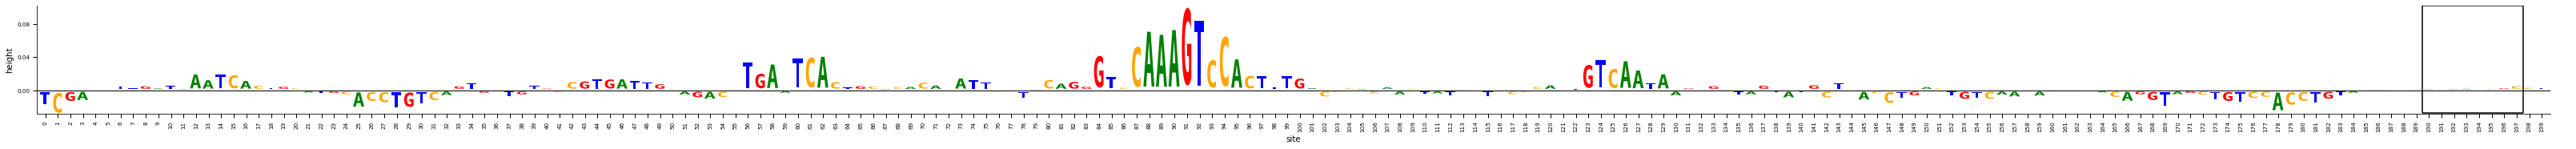

20211214_94001__624120__768::sa_rep__k562__0


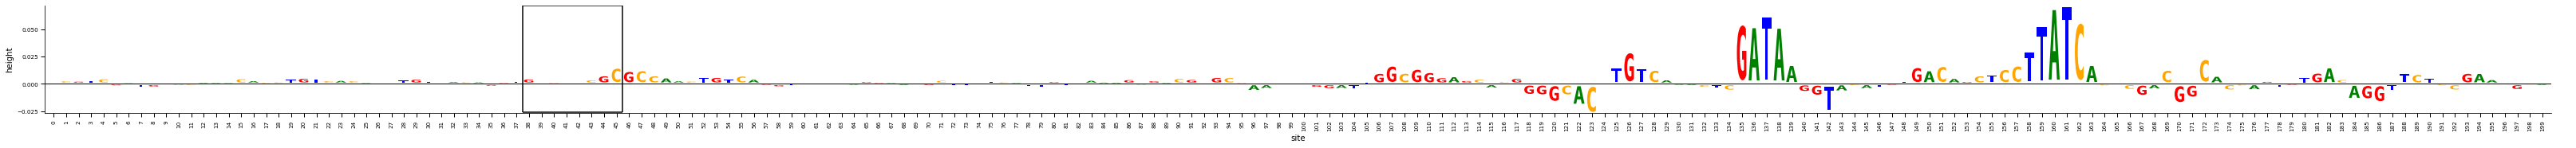

20211214_94001__624120__2121::sa_rep__k562__0


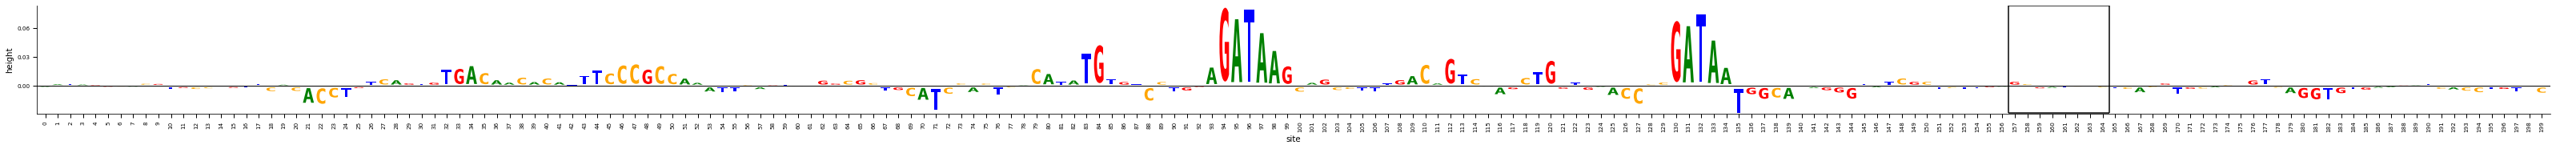

20211214_94001__624120__2314::sa_rep__k562__0


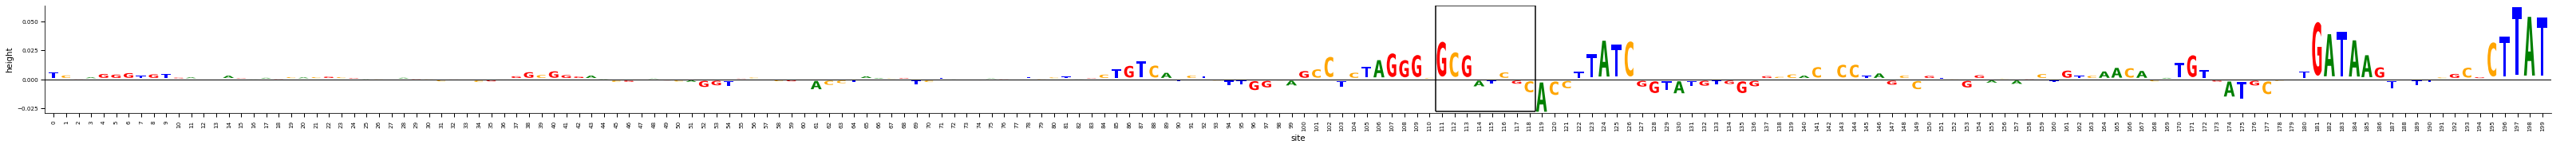

20211214_94001__624120__2374::sa_rep__k562__0


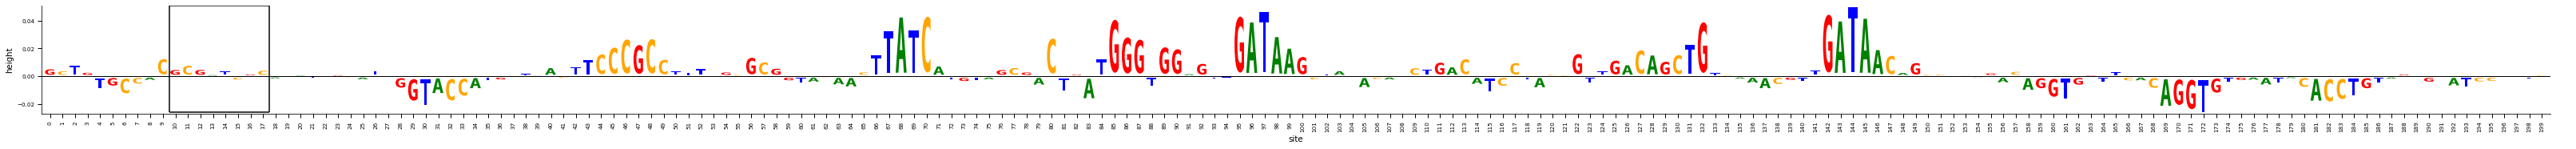

20211214_94001__624120__2759::sa_rep__k562__0


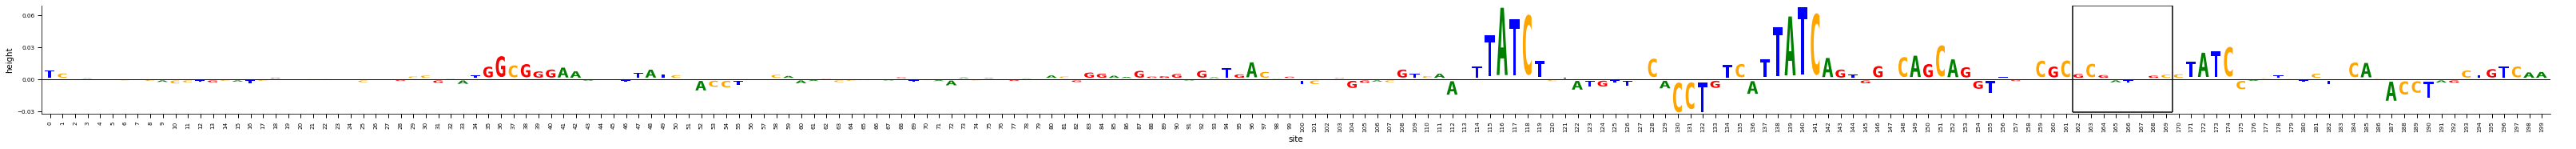

20211214_94001__624120__3127::sa_rep__k562__0


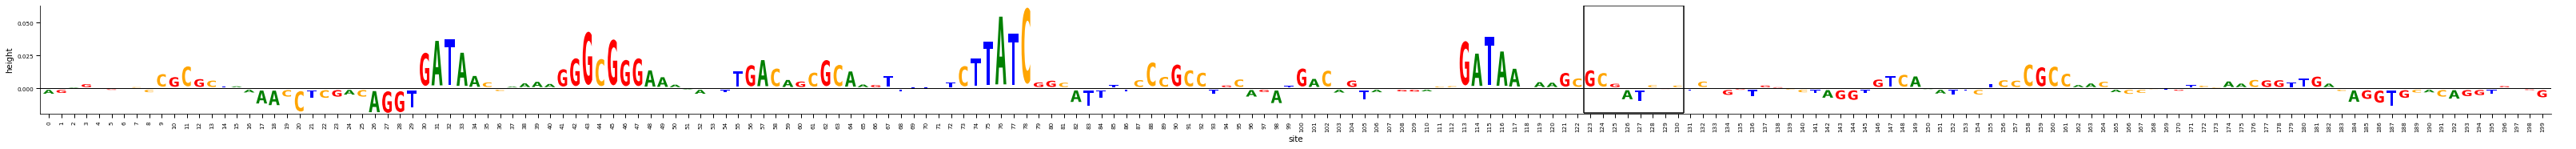

20211214_94001__624120__3144::sa_rep__k562__0


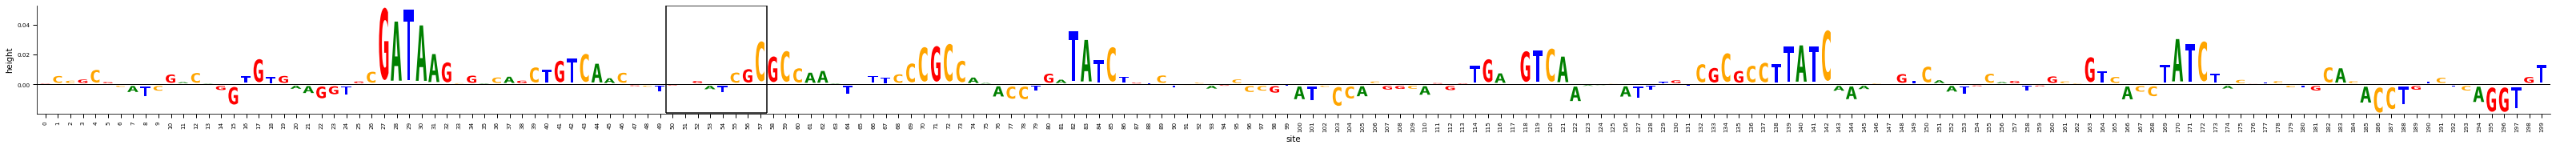

20211214_111905__704605__442::sa_rep__sknsh__0


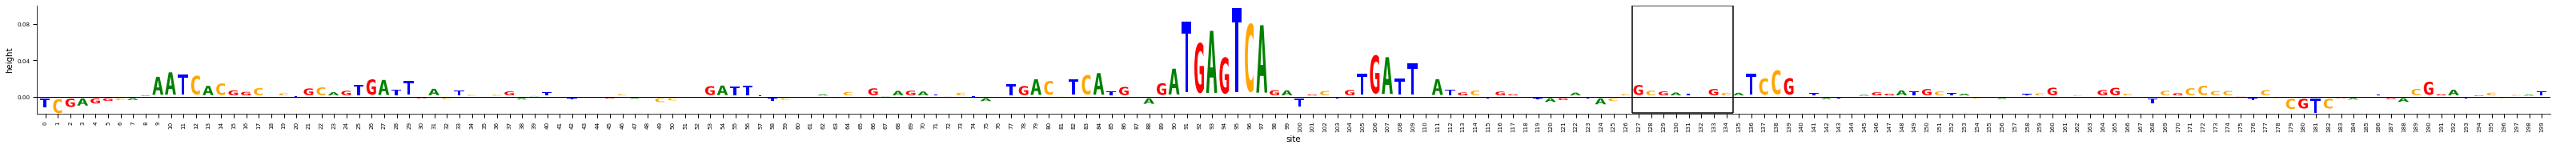

In [156]:
for i in range(all_salient_maps.shape[0]):
    print(sequence_IDs[i])
    matrix = all_salient_maps[i,:,:]
    y_max = matrix.max()
    y_min = matrix.min()
    fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                      axisfontscale=0.6, heightscale=1)    
    site_start = site_idxs[i]
    if site_start == -1:
        site_start = 0
        site_end = site_start + 7
        #plt.vlines(site_start, y_min, y_max, colors='black')
        plt.vlines(site_end, y_min, y_max, colors='black')
        plt.hlines(y_max, site_start, site_end, colors='black')
        plt.hlines(y_min, site_start, site_end, colors='black')
    elif site_start == 193:
        site_end = site_start + 7
        plt.vlines(site_start, y_min, y_max, colors='black')
        #plt.vlines(site_end, y_min, y_max, colors='black')
        plt.hlines(y_max, site_start, site_end, colors='black')
        plt.hlines(y_min, site_start, site_end, colors='black')
    else:
        site_end = site_start + 8
        plt.vlines(site_start, y_min, y_max, colors='black')
        plt.vlines(site_end, y_min, y_max, colors='black')
        plt.hlines(y_max, site_start, site_end, colors='black')
        plt.hlines(y_min, site_start, site_end, colors='black')
    plt.show()

In [ ]:
for i in range(onehot_sequences.shape[0]):
    print(sequence_IDs[i])
    matrix = onehot_sequences[i,:,:]
    y_max = matrix.max()
    y_min = matrix.min()
    fig, ax = matrix_to_dms(matrix, y_max=y_max, fontaspect=.65, widthscale=0.8,
                      axisfontscale=0.6, heightscale=1)
    if bool(torch.any(masks[i,...])):
        site_start = masks[i,...].nonzero().numpy()[0,1]
        site_end = site_start + 8
        plt.vlines(site_start, y_min, y_max, colors='black')
        plt.vlines(site_end, y_min, y_max, colors='black')
        plt.hlines(y_max, site_start, site_end, colors='black')
        plt.hlines(y_min, site_start, site_end, colors='black')
    else:
        print('No site found')
        print('')
    plt.show()